# Modeling for Sales Forecast 

## *Table of Contents*

[1. XGBoost LGB Model](#1-xgboost-lgm-model)

[2. XGBoost Model](#2-xgboost-model)

[3. SARIMA Model](#3-sarima-model)

[4. Forecast "Transactions" Using XGBoost Model](#4-forecast-transactions-using-xgboost-model)

## Import the dataset

In [59]:
# Import the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats

In [60]:
# import the dataset 
def import_csv(path,delimiter = ","):
    return pd.read_csv( path, delimiter = delimiter)

holidays_events = import_csv("cleaned_holidays_events.csv")
oil_df = import_csv("cleaned_oil.csv")
stores_df = import_csv("cleaned_stores.csv")
test = import_csv("extended_test.csv")
transactions = import_csv("transactions_adjusted.csv")
train = import_csv("train_adjusted.csv",delimiter=";")



In [61]:

family_info = pd.read_csv("family_info.csv",delimiter=";")

## 1. XGBoost LGM Model

In [62]:
# Import libraries 
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

### 1.1 Prepare the dataframe

In [63]:
# Assign variables to the dataframes
df_train = train
df_holidays = holidays_events
df_stores = stores_df
df_oil = oil_df


#convert date string into dt
df_train['date'] = pd.to_datetime(df_train['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
test['date'] = pd.to_datetime(test['date'])


# Merge train and test dataframes 
df_train = pd.concat([df_train, test], ignore_index=True)

# Drop columns that are not needed 
df_train = df_train.drop(columns=['Year','YearMonth','Month'], axis=1)

# Merge with df_oil 
df_train = df_train.merge(df_oil,on='date',how='left')
df_train['dcoilwtico'] = df_train['dcoilwtico'].ffill()

# Fill missing dcoilwtico values with the next value 
df_train['dcoilwtico'] = df_train['dcoilwtico'].bfill()


In [64]:
# Merge df_train with family_info
df_train = df_train.merge(family_info,on='family',how='left')

In [65]:
df_original = df_train.copy()

In [66]:
#remove "Traslado" from event name
df_holidays['description'] = df_holidays['description'].str.replace('^Traslado ', '', regex=True)

#matching holidays
df_train = pd.merge(df_train, df_stores, on='store_nbr', how = 'left')
df_holidays['city'] = df_holidays['locale_name']
df_holidays['state'] = df_holidays['locale_name']

# Match local holidays 
holiday_local = df_holidays[df_holidays['locale'] == 'Local'].groupby(['date','city'])['description'].max().reset_index()
holiday_local['temp_col'] = 1

df_train = pd.merge(df_train, holiday_local[['date', 'city', 'temp_col']], on=['date', 'city'], how='left')
df_train['holiday_local'] = df_train['temp_col'].fillna(0).astype(int)
df_train.drop(columns=['temp_col'], inplace=True)

# Match regional holidays 
regional_holidays = df_holidays[df_holidays['locale'] == 'Regional'].groupby(['date','state'])['description'].max().reset_index()
regional_holidays['temp_col'] = 1

df_train = pd.merge(df_train, regional_holidays[['date', 'state', 'temp_col']], on=['date', 'state'], how='left')
df_train['holiday_regional'] = df_train['temp_col'].fillna(0).astype(int)
df_train.drop(columns=['temp_col'], inplace=True)

# Match national holidays
national_holidays = df_holidays[df_holidays['locale'] == 'National'].groupby(['date'])['description'].max().reset_index()
national_holidays['temp_col'] = 1

df_train = pd.merge(df_train, national_holidays[['date', 'temp_col']], on=['date'], how='left')
df_train['holiday_national'] = df_train['temp_col'].fillna(0).astype(int)
df_train.drop(columns=['temp_col'], inplace=True)

#combine holidays
df_train['holiday'] = df_train['holiday_local'] + df_train['holiday_regional'] + df_train['holiday_national']
df_train['is_holiday'] = df_train['holiday'].apply(lambda x:1 if x>0 else 0)
df_train.drop(columns=['holiday_local', 'holiday_regional', 'holiday_national','city', 'state'], inplace=True)


In [67]:
#add weekday and month
df_train['weekday'] = df_train['date'].dt.weekday
df_train['month'] = df_train['date'].dt.month
df_train['1st_jan'] = np.logical_and(df_train['date'].dt.month == 1, df_train['date'].dt.day == 1) * 1
df_train['is_weekend'] = df_train['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

#Add sales time-series data
df_train['sales_7_ago'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(7)
df_train['sales_30_ago'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(30)
df_train['sales_last_year'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(365)
df_train['sales_7_mean'] = (
    df_train.groupby(['family', 'store_nbr'])['sales']
    .rolling(window=7, min_periods=7, closed= 'left')  # closed = 'left' means ignoring the latest datapoint in the rolling windows
    .mean()
    .reset_index(level=[0, 1], drop=True)
)
df_train['sales_30_mean'] = (
    df_train.groupby(['family','store_nbr'])['sales']
    .rolling(window = 30, min_periods=30, closed= 'left')
    .mean().reset_index(level=[0,1],drop=True)
)

# time delta between the date and the first date in the dataset
df_train['day_n'] = (df_train['date'] - np.min(df_train['date'])).dt.days 

In [68]:
# Add function to check data integrity after feature engineering
def verify_data_integrity(original_df, transformed_df):
    # Check 1: Row count
    if len(original_df) != len(transformed_df):
        print(f"⚠️ Row count mismatch: {len(original_df)} vs {len(transformed_df)}")
    else:
        print(F"✅ Row count matches: {len(original_df)}")
    
    # Check 2: Identify key columns
    key_cols = ['id','date', 'store_nbr', 'family']
    missing_keys = [col for col in key_cols if col not in transformed_df.columns]
    if missing_keys:
        print(f"⚠️ Missing key columns in transformed data: {missing_keys}")
        return
    
    # Check 3: Merge and compare sales
    merged = original_df[key_cols + ['sales']].merge(
        transformed_df[key_cols + ['sales']], 
        on=key_cols, 
        suffixes=('_orig', '_trans')
    )
    sales_diff = (merged['sales_orig'] != merged['sales_trans']) & ~(merged['sales_orig'].isna() & merged['sales_trans'].isna())
    
    if sales_diff.any():
        print(f"⚠️ {sales_diff.sum()} rows have different 'sales' values between original and transformed data.")
        diff_sales = merged[merged['sales_orig'] != merged['sales_trans']]
        print(diff_sales[['date', 'store_nbr', 'family', 'sales_orig', 'sales_trans']].head(10))
    else:
        print("✅ 'sales' values match exactly.")
    
    # Check 4: Check for NaNs in sales
    if transformed_df['sales'].isna().sum() != original_df['sales'].isna().sum():
        print("⚠️ Number of NaNs in 'sales' has changed.")
    else:
        print("✅ NaN count in 'sales' unchanged.")

    print("✔️ Integrity check complete.")

verify_data_integrity(df_original, df_train)

✅ Row count matches: 3679830
✅ 'sales' values match exactly.
✅ NaN count in 'sales' unchanged.
✔️ Integrity check complete.


In [ ]:
# Drop 'id' column 
df_train = df_train.drop(columns=['id'], axis=1)


### 1.2 Features Creation

In [71]:
col_list = df_train.columns.to_list
col_list

<bound method IndexOpsMixin.tolist of Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico',
       'category', 'type', 'cluster', 'holiday', 'is_holiday', 'weekday',
       'month', '1st_jan', 'is_weekend', 'sales_7_ago', 'sales_30_ago',
       'sales_last_year', 'sales_7_mean', 'sales_30_mean', 'day_n'],
      dtype='object')>

In [72]:
# Prepare feature columns 
fearture_cols = ['store_nbr', 'family', 'holiday','onpromotion',
       'weekday', 'month', '1st_jan', 'sales_7_ago','type','cluster',
       'sales_30_ago', 'sales_7_mean', 'sales_30_mean', 'day_n','dcoilwtico']
categorical_columns = ['family','store_nbr','weekday','month','type','cluster']

for col in categorical_columns:
    df_train[col] = df_train[col].astype('category')

In [73]:
end_date_original = df_train[df_train['sales'].notnull()]['date'].max() 
end_date_original

Timestamp('2017-08-15 00:00:00')

In [74]:
# Split the data into train and test sets
split_date = '2016-06-01' # Split the test data from 2016 onward
train_data = df_train[df_train['date']< split_date].copy()
test_data = df_train[(df_train['date']>= split_date) & (df_train['date']<=end_date_original)].copy()

# Prepare training data form model 
X_train = train_data[fearture_cols].copy()
y_train = train_data['sales'].copy()
X_test = test_data[fearture_cols].copy()
y_test = test_data['sales'].copy()

# LGB dataset 
train_lgb = lgb.Dataset(X_train,label = y_train,categorical_feature=categorical_columns)
test_lgb = lgb.Dataset(X_test,label=y_test,categorical_feature=categorical_columns,reference=train_lgb)

### 1.3 Build the Model

In [75]:
# Build the model
params = {
    'boosting_type':'gbdt',
    'objective':'tweedie',
    'metric':'rmse',
    'num_leaves':31,
    'learning_rate': 0.05,
    'feature_fraction':0.9,
    'seed' : 13
}

num_round = 1000
callbacks = [early_stopping(50)]

# Train the model 
lgb_model = lgb.train(params,train_lgb,num_round,valid_sets=[train_lgb,test_lgb],callbacks=callbacks)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2216808, number of used features: 15
[LightGBM] [Info] Start training from score 5.770003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	training's rmse: 769.546	valid_1's rmse: 902.236


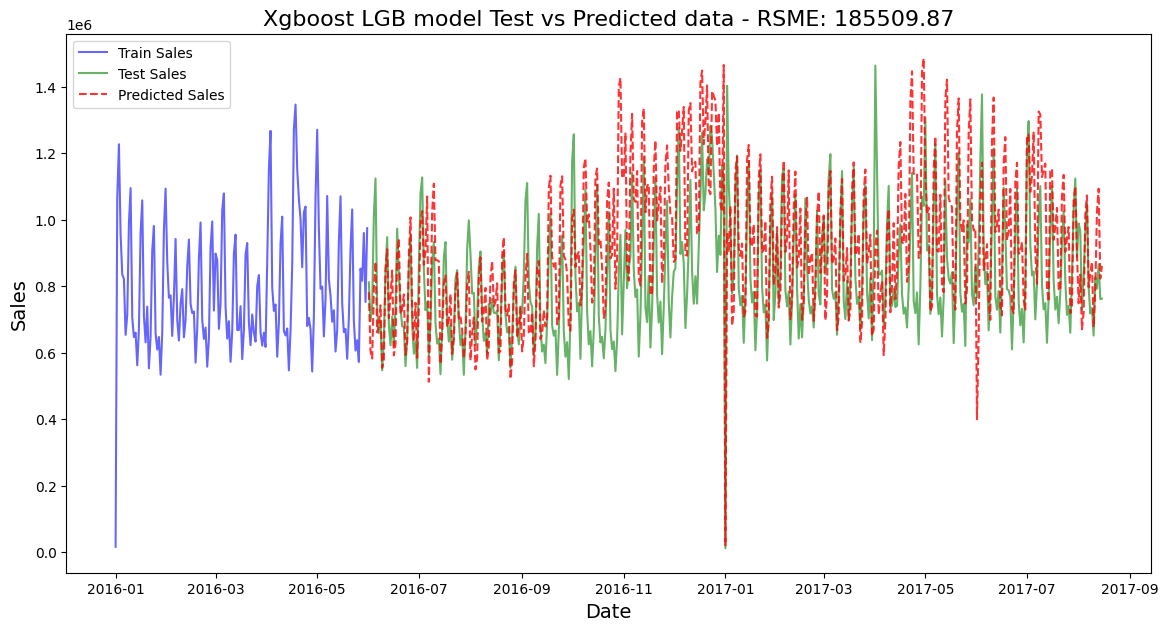

In [76]:
# Predict the sales 
y_pred = lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration)


# Prepare the dataset for plotting
y_train = train_data.groupby('date')['sales'].sum().reset_index()
y_train = y_train.set_index('date')

test_data['sales_pred'] = y_pred
test_group = test_data.groupby('date')[['sales','sales_pred']].sum().reset_index()
test_group = test_group.set_index('date')


# Retrieve the rsme of the model
lgb_rsme = np.sqrt(mean_squared_error(test_group['sales'],test_group['sales_pred']))

# Plot the actual and predicted sales
plt.figure(figsize=(14, 7))

# Plot y_train
plt.plot(y_train.loc['2016-01-01':].index, y_train.loc['2016-01-01':]['sales'], label='Train Sales', color='blue', alpha=0.6)

# Plot y_test
plt.plot(test_group.index, test_group['sales'], label='Test Sales', color='green', alpha=0.6)

# Plot y_pred
plt.plot(test_group.index, test_group['sales_pred'], label='Predicted Sales',linestyle="--", color='red', alpha=0.8)

plt.title(f'Xgboost LGB model Test vs Predicted data - RSME: {lgb_rsme:.2f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()
plt.show()

In [93]:
# Create a FC sales data to simulate the application of the model since'2014-01-01' 
X_test = df_train[(df_train['date']<= end_date_original) & (df_train['date']>= pd.to_datetime('2014-01-01'))][fearture_cols].copy()
y_test = df_train[df_train['date']<= end_date_original]['sales'].copy()

total_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

total_fc = df_train[(df_train['date']<= end_date_original) & (df_train['date']>= pd.to_datetime('2014-01-01'))].copy()
total_fc['sales_FC'] = total_pred
total_fc = total_fc[['date','store_nbr','family','sales_FC','onpromotion']].copy()

total_fc

,date,store_nbr,family,sales_FC,onpromotion
648648,2014-01-01,41,GROCERY I,0.047665,0
648649,2014-01-01,41,PRODUCE,0.038090,0
648650,2014-01-01,41,SEAFOOD,0.040110,0
648651,2014-01-01,42,PRODUCE,0.000009,0
648652,2014-01-01,42,GROCERY I,0.000006,0
...,...,...,...,...,...
3000883,2017-08-15,25,BEAUTY,38.663910,0
3000884,2017-08-15,25,GROCERY I,628.478614,8
3000885,2017-08-15,25,PRODUCE,43.730565,0
3000886,2017-08-15,26,PRODUCE,28.949000,0


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

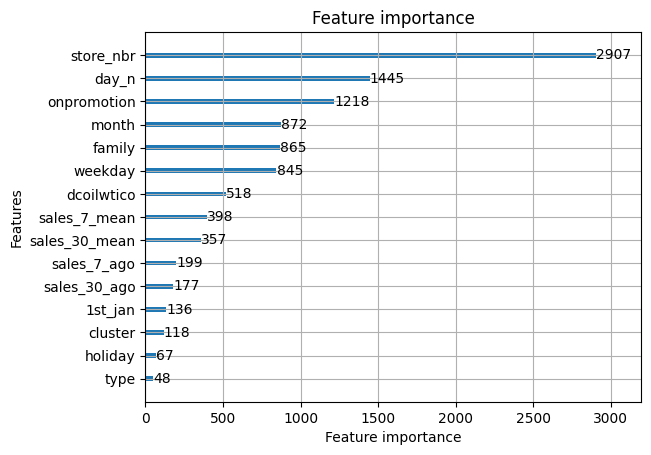

In [90]:
lgb.plot_importance(lgb_model)

### 1.4 Future Sales Forecast

In [79]:
fc_period = pd.to_datetime('2017-08-16') + pd.DateOffset(months=12) # forercast into 12 months in the future 

# Prepare the data for prediction 
predict_data = df_train[df_train['date']<=fc_period].copy()
predict_data['date'] = pd.to_datetime(predict_data['date'])

# Create rolling lag feature columns and leave them as null
predict_data['sales_7_ago_roll'] = np.nan 
predict_data['sales_30_ago_roll'] = np.nan 
predict_data['sales_7_mean_roll'] = np.nan
predict_data['sales_30_mean_roll'] = np.nan

#  Seed the predictions with real sales for historical period
predict_data['fc_sales_roll'] = predict_data['sales']

# Create a list of date in the desired forecast period 

forecast_period = pd.date_range(start=end_date_original + pd.Timedelta(days=1), end=fc_period, freq='D')
forecast_dates = [pd.to_datetime(date) for date in forecast_period]

# Feature columns for test dataframe 
fearture_cols_roll = ['store_nbr', 'family', 'holiday','onpromotion',
       'weekday', 'month', '1st_jan', 'sales_7_ago_roll','type','cluster',
       'sales_30_ago_roll', 'sales_7_mean_roll', 'sales_30_mean_roll', 'day_n','dcoilwtico']


# Predict sales step by step, use the predicted value to predict the next value
for date in forecast_dates:
    # Calculate lag feature based on latest prediction 
    predict_data['sales_7_ago_roll'] = predict_data.groupby(['family','store_nbr'],observed=False)['fc_sales_roll'].shift(7)
    predict_data['sales_30_ago_roll'] = predict_data.groupby(['family','store_nbr'],observed=False)['fc_sales_roll'].shift(30)
    predict_data['sales_7_mean_roll'] = (predict_data.groupby(['family','store_nbr'],observed=False)['fc_sales_roll']
                                        .rolling(window=7,min_periods=7,closed='left')
                                        .mean().reset_index(level=[0,1],drop=True)
                                        )
    predict_data['sales_30_mean_roll'] = (predict_data.groupby(['family','store_nbr'],observed=False)['fc_sales_roll']
                                        .rolling(window=30,min_periods=30,closed='left')
                                        .mean().reset_index(level=[0,1],drop=True)
                                        )
    # Prepare the dataframe to predict the sales for the current date 
    mask = predict_data['date'] == date
    predict_set = predict_data.loc[mask,fearture_cols_roll].copy()
    for col in categorical_columns:
        predict_set[col] = predict_set[col].astype('category')
    
    forecast_output = lgb_model.predict(predict_set,num_iteration=lgb_model.best_iteration)
    predict_data.loc[mask,'fc_sales_roll'] = np.round(forecast_output,0)


# Overwrite predict_data['sales'] with fc_sales_roll
# predict_data.loc[predict_data['date'] > end_date_original, 'sales'] = predict_data['fc_sales_roll']


In [94]:
# Read the forecasted data 
sales_wfc = predict_data[['date','store_nbr','family','onpromotion','fc_sales_roll']].copy()
sales_wfc = sales_wfc.rename(columns={'fc_sales_roll':'sales'})

# Rearrange columns in sales_wfc and sort by date
sales_wfc = sales_wfc[['date', 'store_nbr', 'family', 'sales', 'onpromotion']]
sales_wfc['date'] = pd.to_datetime(sales_wfc['date'])
sales_wfc = sales_wfc.sort_values('date')

# Future sales forecast slice 
sales_wfc_future = sales_wfc[sales_wfc['date'] > end_date_original].copy()

# Read and sort previously forecasted data (forecast past data)
total_fc = total_fc.rename(columns={'sales_FC': 'sales'})
total_fc['date'] = pd.to_datetime(total_fc['date'])
total_fc = total_fc.sort_values('date')

# Combine the two dataframes to create a complete forecast dataset from 2014 to middle of 2018
total_fc = pd.concat([total_fc,sales_wfc_future],axis=0)
total_fc['status'] = 'FC'

total_fc.to_csv("xgboost_result_full.csv",index=False,header=True,sep=';')


In [85]:
predict_group = sales_wfc.groupby('date')[['sales']].sum().reset_index()
predict_group = predict_group.set_index('date')
predict_group

,sales
date,
2013-01-01,2.511619e+03
2013-01-02,4.960924e+05
2013-01-03,3.614612e+05
2013-01-04,3.544597e+05
2013-01-05,4.773501e+05
...,...
2018-08-12,1.065208e+06
2018-08-13,8.865150e+05
2018-08-14,8.394900e+05


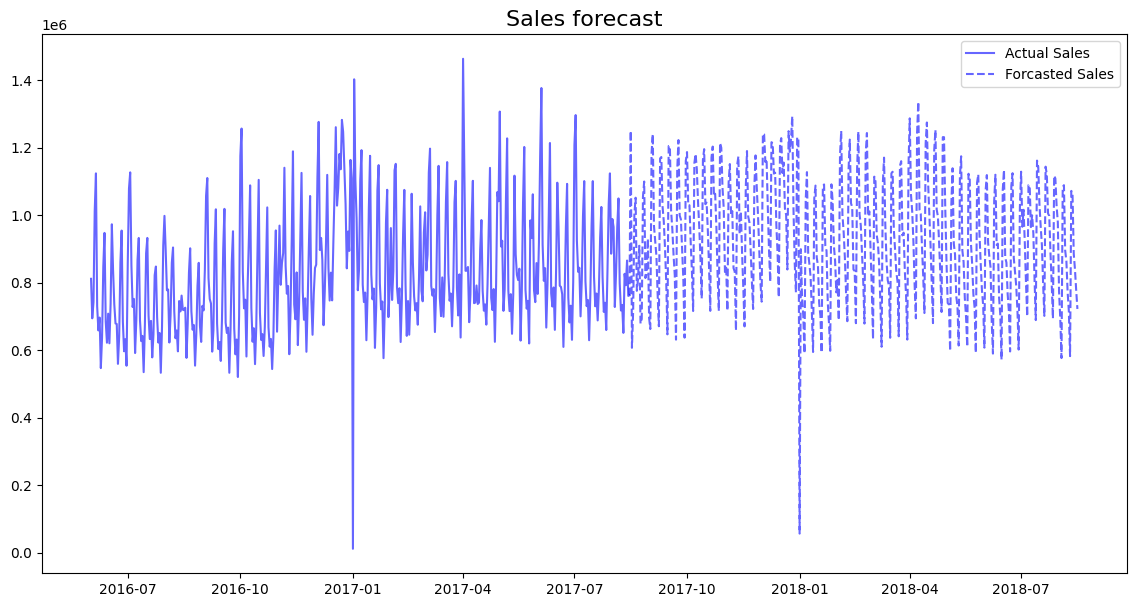

In [86]:

# Prepare the data for plotting future predictions 
df_group = df_train.groupby('date')['sales'].sum().reset_index()
df_group = df_group.set_index('date')


# Plot the actual and predicted sales
plt.figure(figsize=(14,7))

plt.plot(df_group.loc['2016-06-01':'2017-08-15'].index,df_group.loc['2016-06-01':'2017-08-15']['sales'],label= 'Actual Sales',color = 'blue',alpha = 0.6)
plt.plot(predict_group.loc[end_date_original:].index,predict_group.loc[end_date_original:]['sales'],label = 'Forcasted Sales', color = 'blue', alpha = 0.6,linestyle="--")

plt.title('Sales forecast',fontsize = 16)
plt.legend()

plt.show()

### 1.5 Analyze sales after forecast 

In [66]:
df_group = df_train.groupby('date')['sales'].sum().reset_index()
df_group['year'] = df_group['date'].dt.year
df_group['month'] = df_group['date'].dt.month

df_group_2016 = df_group[df_group['year'] == 2016].copy()
df_group_2016 = df_group_2016.groupby('month')['sales'].sum().reset_index()

df_group_2016

,month,sales
0,1,2.397780e+07
1,2,2.194741e+07
2,3,2.313178e+07
3,4,2.596303e+07
4,5,2.879426e+07
5,6,2.220922e+07
6,7,2.362300e+07
7,8,2.319808e+07
8,9,2.241745e+07
9,10,2.403039e+07


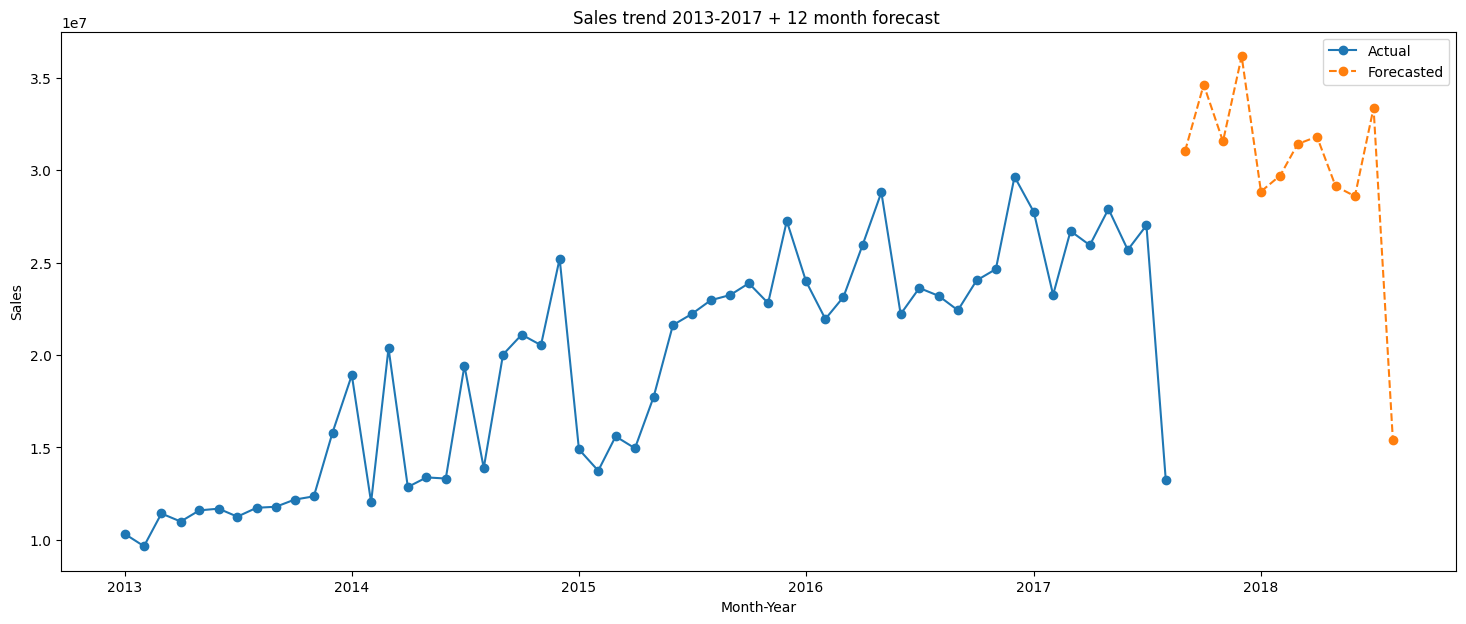

In [ ]:
# Prepare the data set for monthly sales 
sales_by_month = predict_group['sales'].resample('MS').sum()
df_group_monthly = df_group['sales'].resample('MS').sum()

end_date_original = pd.to_datetime(end_date_original)
act_sales_by_month = df_group_monthly[df_group_monthly.index <= end_date_original]
fc_sales_by_month = sales_by_month[sales_by_month.index >= end_date_original]

# Plot the sales trend from 
plt.figure(figsize=(18,7))

plt.plot(act_sales_by_month.index, act_sales_by_month.values,marker = 'o',label = 'Actual')
plt.plot(fc_sales_by_month.index,fc_sales_by_month.values, linestyle= '--', marker = 'o',label ='Forecasted')

plt.title('Sales trend 2013-2017 + 12 month forecast ')
plt.xlabel("Month-Year")
plt.ylabel("Sales")
plt.legend()

plt.show()

### 1.6 Manually adjust the forecast result for 2017

In [54]:
total_fc = import_csv("xgboost_result_full.csv",delimiter=";")

daily_fc = total_fc.groupby('date')['sales'].sum().reset_index()
daily_fc['date'] = pd.to_datetime(daily_fc['date'])
daily_fc = daily_fc.rename(columns={'sales': 'fc_sales'})

daily_fc

,date,fc_sales
0,2014-01-01,5.628535e+03
1,2014-01-02,5.302080e+05
2,2014-01-03,5.433954e+05
3,2014-01-04,7.551786e+05
4,2014-01-05,7.860040e+05
...,...,...
1681,2018-08-12,1.262603e+06
1682,2018-08-13,1.043511e+06
1683,2018-08-14,9.381030e+05
1684,2018-08-15,9.187200e+05


In [60]:
# Create yearly sales data with actual and forecasted sales
total_data = pd.merge(df_group,daily_fc,on='date',how='outer')
total_data = total_data.fillna(0)

# Create FC sales after end_date_original
total_data['fc_sales_17'] = np.where(total_data['date'] > end_date_original, total_data['fc_sales'], 0)

# Create yearly sales table 
total_data['date']= pd.to_datetime(total_data['date'])
total_data['year'] = total_data['date'].dt.year
yearly_sales = total_data.groupby('year')[['act_sales','fc_sales','fc_sales_17']].sum().reset_index()

yearly_sales['final_sales'] = yearly_sales['act_sales'] + yearly_sales['fc_sales_17']
yearly_sales['Current_Gr'] = yearly_sales['final_sales'].pct_change()*100


In [61]:
yearly_sales

,year,act_sales,fc_sales,fc_sales_17,final_sales,Current_Gr
0,2013,1.408219e+08,0.000000e+00,0.0,1.408219e+08,NaN
1,2014,2.110488e+08,2.061542e+08,0.0,2.110488e+08,49.869284
2,2015,2.408801e+08,2.345536e+08,0.0,2.408801e+08,14.134780
3,2016,2.935753e+08,3.286502e+08,0.0,2.935753e+08,21.876130
4,2017,1.974721e+08,3.845790e+08,149465262.0,3.469374e+08,18.176599
5,2018,0.000000e+00,2.282366e+08,228236567.0,2.282366e+08,-34.213897


Adjust the 

## 2. XGBoost Model 
### 2.1 Feature Creations

In [ ]:
fearture_cols

['store_nbr',
 'family',
 'holiday',
 'onpromotion',
 'weekday',
 'month',
 '1st_jan',
 'sales_7_ago',
 'type',
 'cluster',
 'sales_30_ago',
 'sales_7_mean',
 'sales_30_mean',
 'day_n',
 'dcoilwtico']

In [ ]:

from sklearn.preprocessing import LabelEncoder

df_train_act = df_train[df_train['date'] <= end_date_original].copy()
# Create timeseries features based on time series index:
def encode_features(df,feature):

    le = LabelEncoder()
    for column in feature:
        df[column] = le.fit_transform(df[column])
    return df

# Example usage:

df_train_encoded = encode_features(df_train_act, categorical_columns)


### 2.2 Transform the dataset 
Compare different transformation on target value


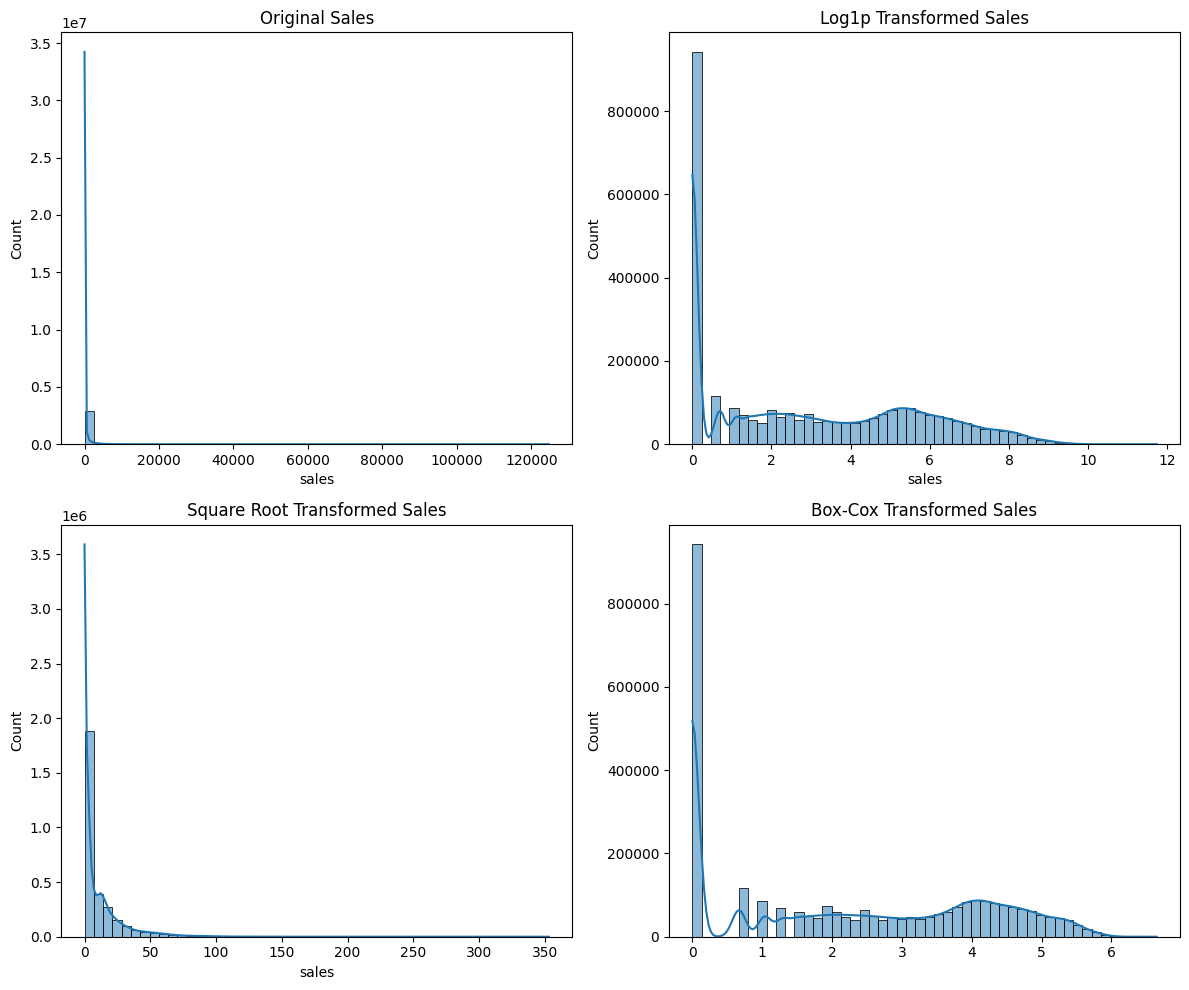

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original sales
sns.histplot(df_train_act['sales'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Original Sales")

# Log transformation (Handle zeros with log1p)
sns.histplot(np.log1p(df_train_act['sales']), bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Log1p Transformed Sales")

# Square root transformation
sns.histplot(np.sqrt(df_train_act['sales']), bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Square Root Transformed Sales")

# Box-Cox transformation 
from scipy.stats import boxcox

sales_positive = df_train_act['sales'] + 1  # Ensure no zeros
sales_boxcox, _ = boxcox(sales_positive)
sns.histplot(sales_boxcox, bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Box-Cox Transformed Sales")

plt.tight_layout()
plt.show()

Since both Box-Cox and logarith transformation have similar result, choose the logarith transform for xgboost model
### 2.3 Build the model

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Prepare the data for the model
X_train = df_train_encoded[df_train_encoded['date'] < split_date][fearture_cols].copy()
X_test = df_train_encoded[df_train_encoded['date'] >= split_date][fearture_cols].copy()

y_train = df_train_encoded[df_train_encoded['date'] < split_date]['sales'].copy()
y_train_log = np.log1p(y_train)
y_test = df_train_encoded[df_train_encoded['date'] >= split_date]['sales'].copy()
y_test_log = np.log1p(y_test)

In [ ]:
# Initialize the model
model = XGBRegressor(objective='reg:squarederror', learning_rate=0.05, n_estimators=500, max_depth=5)
model.fit(X_train, y_train_log)

# Make predictions
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred) # reverse log transformation

# Calculate the RMSE
xg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {xg_rmse:.2f}")

RMSE: 918.12


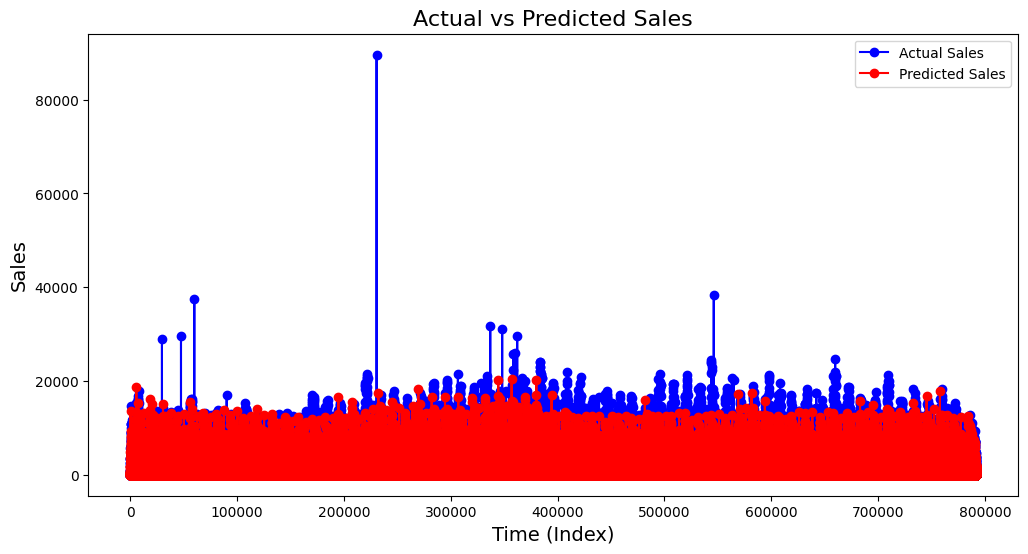

In [ ]:
# Plot the actual vs predicted sales
y_test_reset = y_test.reset_index(drop=True)

# Create an array of the same length as y_test and y_pred to serve as a pseudo-time index
pseudo_time = np.arange(len(y_test_reset))

plt.figure(figsize=(12, 6))
plt.plot(pseudo_time, y_test_reset, label='Actual Sales', marker='o',color='blue')
plt.plot(pseudo_time, y_pred, label='Predicted Sales', marker='o',color='red')

plt.title('Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Time (Index)', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()

plt.show()

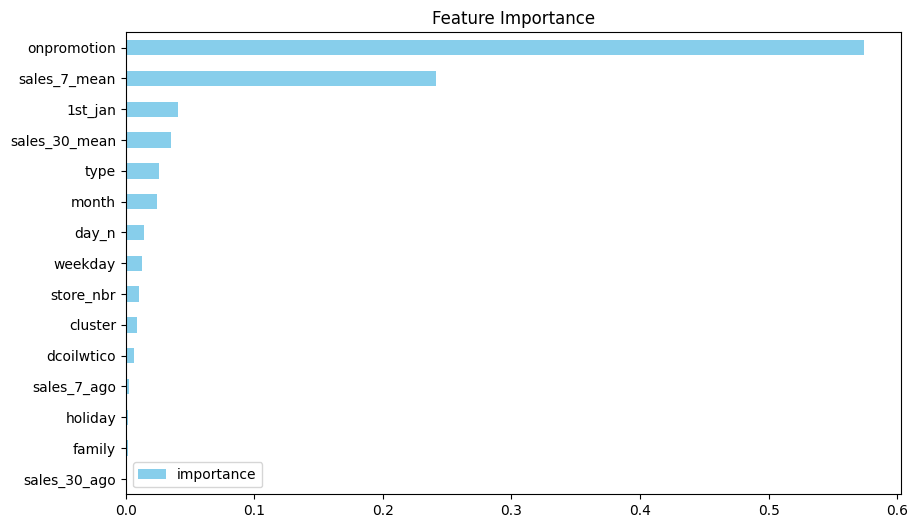

In [ ]:
important_feat = pd.DataFrame(model.feature_importances_,index=model.feature_names_in_,columns=['importance']).sort_values('importance',ascending=True)
# Plot the feature importance
important_feat.plot(kind='barh',figsize=(10,6),title='Feature Importance',color='skyblue')
plt.show()

### 2.4 Hyperparameter finetuning 

In [ ]:
# # Define the hyperparameters for the model
# param_grid = {
#     'n_estimators': [100, 200, 300], 
#     'max_depth': [3, 5, 7], 
#     'learning_rate': [0.01, 0.05, 0.1], 
#     }

# # Initialize the XGBRegressor
# model = xgb.XGBRegressor(objective='reg:squarederror')

# # Split the data set using TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)


# # Use GridSearch with TimeSeriesSplit

# grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit the model
# grid_search.fit(X, Y_log)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# # Get the best model 
# best_xgb_model = grid_search.best_estimator_

In [ ]:
# Prepare the data for date by date 


## 3.  SARIMA model 
### 3.1 Data handling and Transformation

In [ ]:
# Import necessary libraries
import itertools
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")


In [ ]:
df = import_csv("train_adjusted.csv",";")
# Prepare a df for the model 

df['date'] = pd.to_datetime(df['date'])
# Sum sales by date for each year
df = df.groupby('date')['sales'].sum().reset_index()

# Set 'date' as the index and frequency
df.set_index('date', inplace=True)
df = df.asfreq('D')

# Fill missing sales value (if any) with 0
df['sales'] = df['sales'].fillna(0)

#### 3.1.1 Check the stationality of the data set

<Figure size 1000x500 with 0 Axes>

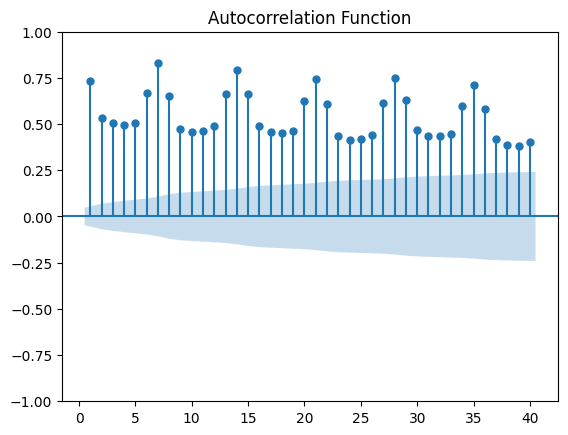

ADF Statistic: -2.5714136301717003
P-Value: 0.0990505835248423


In [ ]:
# ADF test for stationarity
result = adfuller(df['sales'])  


# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(df['sales'], lags=40, zero=False)
plt.title('Autocorrelation Function')

plt.show()
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")


The data is **not stationary** (ADF p value > 0.05). The next step is to difference the data to remove trends and make it stationary.
Perform seasonal differencing to remove weekly cycle.

ACF plots: 
- High correlation at lags 1, 7, 14, etc. → Indicates both a short-term dependency and possible weekly seasonality.
- Slowly decaying ACF → Suggests a trend.
- Significant spikes above the confidence band → Indicates that past values strongly influence future sales.

Check the seasonality of the dataset:

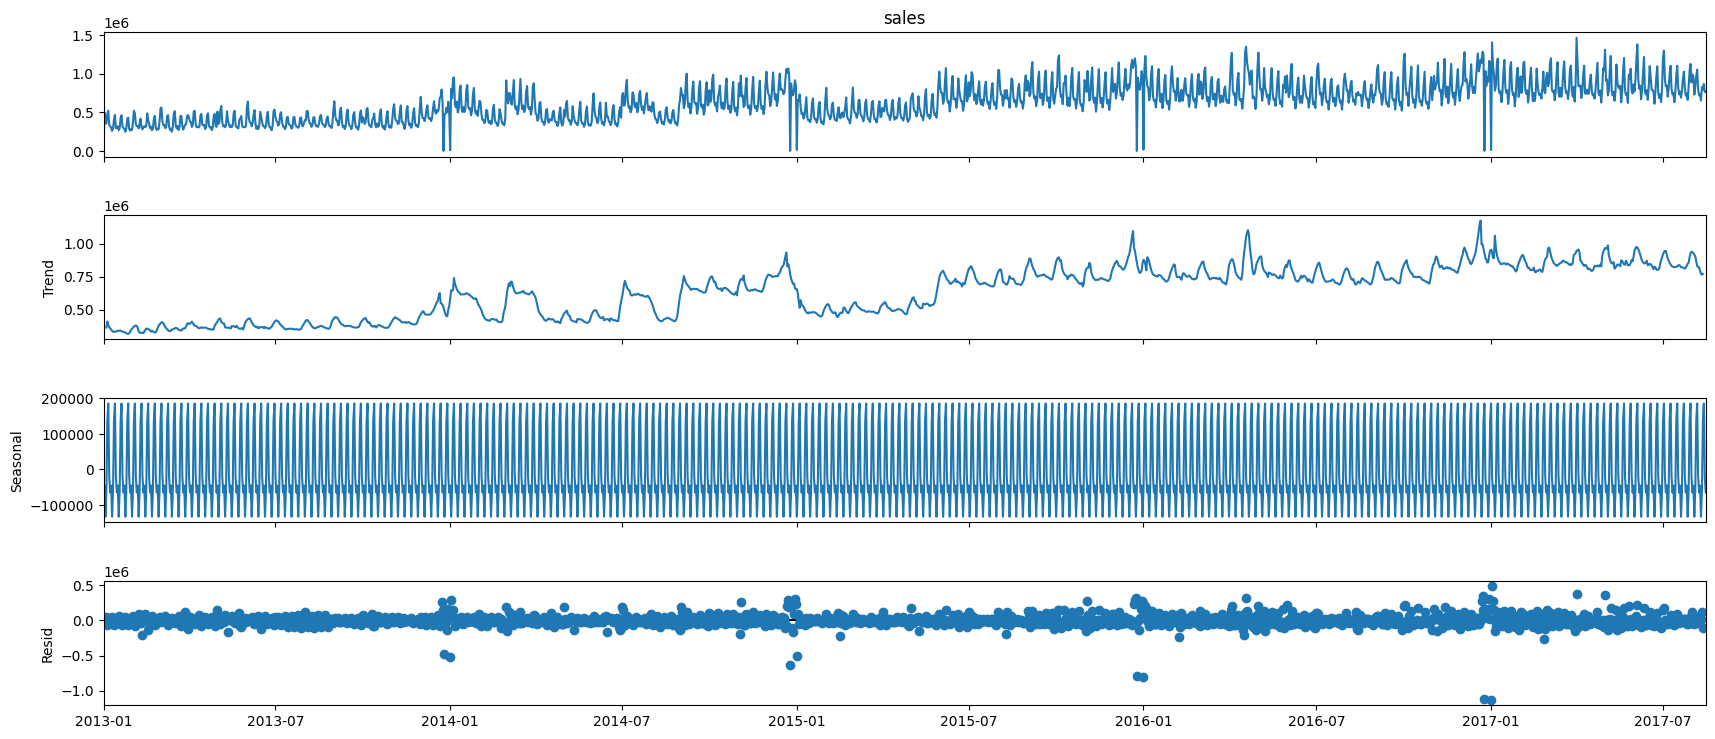

In [ ]:
# Check the seasonality of the dataset 
decomposition = sm.tsa.seasonal_decompose(df['sales'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(20, 8)

plt.show()

- Trend:long-term growing trend 
- Seasonal: repeating weekly pattern
- Residual: Most centered around zero, some outliners indicating noise or special events (sale drop in New Year Eve)

#### 3.1.2 Differencing the dataset 

In [ ]:
# Differencing with period of 7 days 
df['sales_diff_7'] = df['sales'].diff(periods=7)

adf_test = adfuller(df['sales_diff_7'].dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

ADF Statistic: -12.74640327836526
P-value: 8.721278588372721e-24


#### 3.1.3 ACF & PACF plot

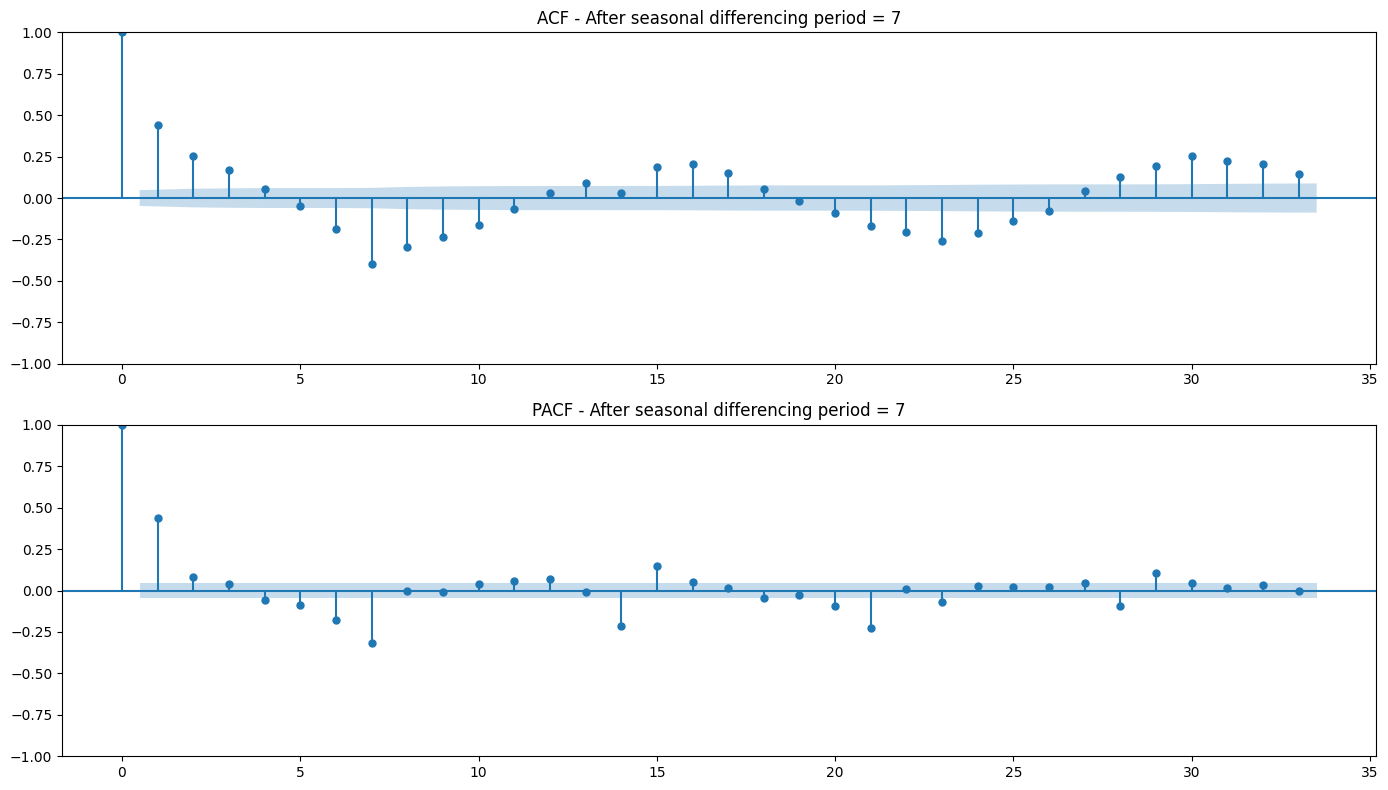

In [ ]:
# Initiate the plot 
fig,axes = plt.subplots(2,1,figsize = (14,8))


# ACF plot 
plot_acf(df['sales_diff_7'].dropna(),ax=axes[0])
axes[0].set_title("ACF - After seasonal differencing period = 7")

# PACF 
plot_pacf(df['sales_diff_7'].dropna(),ax=axes[1])
axes[1].set_title("PACF - After seasonal differencing period = 7")

plt.tight_layout()
plt.show()

### 3.2 Build the model 
#### 3.2.1 Choose model "order"

In [ ]:
# Import the libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Split the data set into training and testing sets
split_date = '2016-06-01'

train_data = df[df.index < split_date]['sales_diff_7']
test_data = df[df.index >= split_date]['sales_diff_7']

train_data_rev = df[df.index < split_date]['sales']
test_data_rev = df[df.index >= split_date]['sales']

In [ ]:
# Create a def function to choose model order 
def best_sarima(df,p,d,q,P,D,Q,seasonal_period):
    warnings.filterwarnings("ignore") # ingnore convergence warning

    best_aic = float("inf")
    best_bic = float("inf")
    best_aic_order = None
    best_bic_order = None
    best_aic_seasonal = None
    best_bic_seasonal = None

    # Iterate over all combinations 
    for order in itertools.product(p,d,q):
        for seasonal_order in itertools.product(P,D,Q):
            seasonal_order_full = seasonal_order + (seasonal_period,)
            try:
                model= SARIMAX(df,order=order,
                               seasonal_order=seasonal_order + (seasonal_period,),
                               enforce_stationarity=False, 
                               enforce_invertibility=False)
                
                results = model.fit(disp = False)

                model_aic = results.aic
                model_bic = results.bic
                
                # Track best AIC model
                if model_aic < best_aic:
                    best_aic = model_aic
                    best_aic_order = order
                    best_aic_seasonal = seasonal_order_full
                
                # Track best BIC model:
                if model_bic < best_bic:
                    best_bic = model_bic 
                    best_bic_order = order 
                    best_bic_seasonal = seasonal_order_full

            except Exception as e:
                print(f"Model SARIMA{order}x{seasonal_order + (seasonal_period,)} failed: {e}")

    print(f"\n✅ Best AIC Model: SARIMA{best_aic_order}x{best_aic_seasonal} - AIC: {best_aic}") 
    print(f"\n✅ Best BIC Model: SARIMA{best_bic_order}x{best_bic_seasonal} - BIC: {best_bic}")   
    return best_aic_order,best_aic_seasonal,best_aic,best_bic_order,best_bic_seasonal,best_bic


# Define the ranges for p, d, q, P, D, Q
p_values = [0,1,2]
d_values = [0]  
q_values = range(0,3)
P_values = range(3,7)
D_values = [0] 
Q_values = range(1,7)
seasonal_period = 7  

# Run the function
best_aic_order,best_aic_seasonal,best_aic,best_bic_order,best_bic_seasonal,best_bic = best_sarima(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_period)


✅ Best AIC Model: SARIMA(2, 0, 2)x(3, 0, 6, 7) - AIC: 30892.55680757858

✅ Best BIC Model: SARIMA(1, 0, 2)x(3, 0, 6, 7) - BIC: 30959.45153541558


#### 3.2.2 Fit the model with test data

In [ ]:
# best_aic_order = [2,0,2]
# best_aic_seasonal = [5,0,4,7]

order = best_aic_order
seasonal_order = best_aic_seasonal

# Train the model with the best "order"
best_sarima_model = SARIMAX(train_data, order = order,
                            seasonal_order = seasonal_order,
                            enforce_invertibility=False, enforce_stationarity=False)

# Fit the SARIMA model 
sarima_results = best_sarima_model.fit(disp=False)
aic_actual = sarima_results.aic

# Forecast with test data 
forecast_diff = sarima_results.forecast(steps = len(test_data))
             

In [ ]:
# Inverse the differencing step 

# Prepare data 

def inverse_difference(df,forecast,periods=7):
    """
    Inverse the differencing step for the forecasted values.
    df : orginal dataframe contain all history data, at least 7 days ealier then the forecasted date.
    forecast : series of forecasted values.
    periods : number of periods used for differencing, by default: 7 days 
    """

    forecast_rev = df['sales'].copy()
    forecast.index = pd.to_datetime(forecast.index)

    # Loop through the forecasted values and add them to the original data
    for ind,i in enumerate(forecast.index):
        lag_date = pd.to_datetime(i) - pd.Timedelta(days=periods)
        # check if the lag_date is in the original data 
        try:
            base_value = forecast_rev.loc[lag_date]
            # base_value = forecast_rev.shift(-periods).loc[lag_date]
        except KeyError:
            raise ValueError(f"Missing data of date {lag_date} in the original data.")
        

        forecast_rev.loc[i] = forecast[i] + base_value
        # if ind <=5: print(f'{forecast_rev.loc[i]} = {forecast[i]} + {base_value}')

    return forecast_rev.loc[forecast.index]    
    
    
# Call the function 
forecast_rev = inverse_difference(df,forecast_diff,7)
# print(forecast_rev.head(10))
# print(df.tail(7))

# Calculate RSME 
sarima_rmse = np.sqrt(mean_squared_error(test_data_rev,forecast_rev))


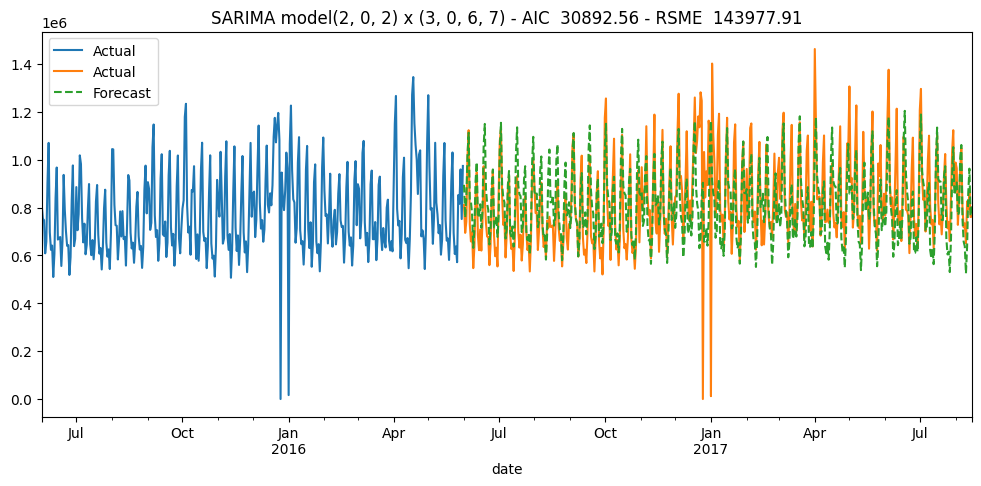

In [ ]:

# Plot the actual vs forecast sales 
train_data_rev['2015-06-01':].plot(legend = True,label= "Actual",figsize=(12,5))
test_data_rev.plot(legend=True, label = "Actual")
forecast_rev.plot(legend= True, label = "Forecast", linestyle = "--")

plt.title(f"SARIMA model{order} x {seasonal_order} - AIC {aic_actual: .2f} - RSME {sarima_rmse: .2f}")
plt.show()

#### 3.2.3 Evaluate the model result on test data

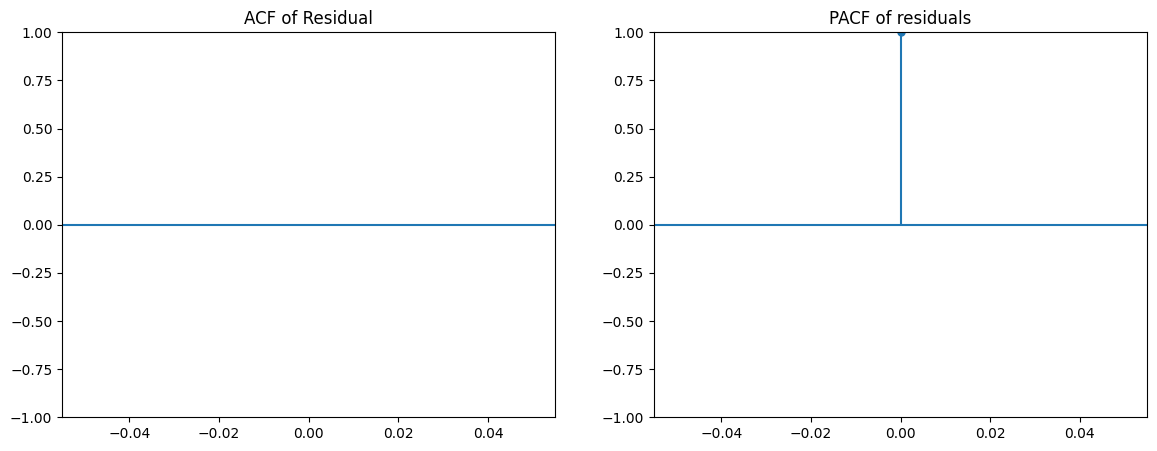

In [ ]:
# Check residuals 
residuals = sarima_results.resid

# Plot ACF & PCAF of the residuals 
fig,ax = plt.subplots(1,2,figsize=(14,5))
plot_acf(residuals, ax=ax[0],title="ACF of Residual")
plot_pacf(residuals, ax=ax[1],title="PACF of residuals")

plt.show()

### 3.3 Forecast into the future
Forecast period: 12 months

In [ ]:
# Train the model with every data point 
best_sarima_model = SARIMAX(df['sales_diff_7'],order=order,
                            seasonal_order = seasonal_order,
                            enforce_invertibility=False,enforce_stationarity=False)

sarima_results = best_sarima_model.fit(disp=False)

"""
ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings
This is a numerical issue and should not materially affect the predictions."""

'\nConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals\n  warnings\nThis is a numerical issue and should not materially affect the predictions.'

In [ ]:
# Forecas for 9 months starting from 2017-08-16
fc_date = pd.to_datetime('2017-08-16')
fc_period = fc_date + pd.DateOffset(months=12)
fc_period_index = pd.date_range(start = '2017-08-16',end=fc_period,freq='D')
fc_steps = len(fc_period_index)

# Get the SARIMA forecast 
future_forecast_diff = sarima_results.forecast(steps=fc_steps)
# Set the index of future_forecast_diff to datetime datatype
future_forecast_diff.index = pd.to_datetime(future_forecast_diff.index)


In [ ]:
# De-difference the forecast 
future_fc_final = inverse_difference(df,future_forecast_diff,7)

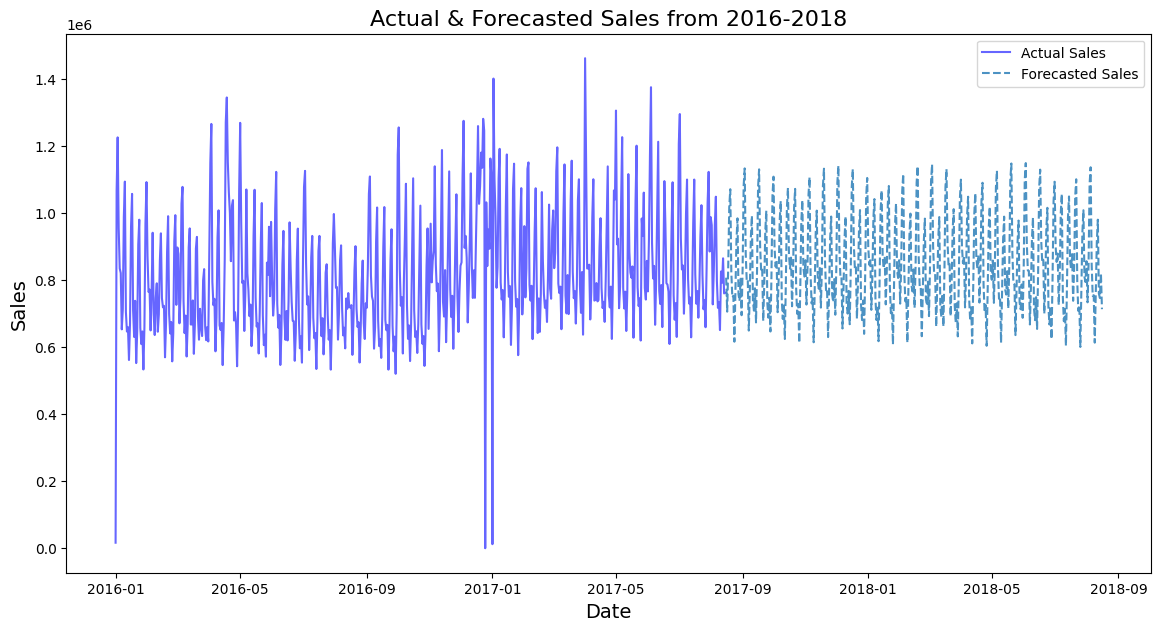

In [ ]:
# Plot the actual and forecasted sales
plt.figure(figsize=(14, 7))

# Plot actual sales
plt.plot(df['sales'].loc['2016-01-01':], label='Actual Sales', color='blue', alpha=0.6)

# Plot forecasted sales
plt.plot(future_fc_final, label='Forecasted Sales', linestyle='--', alpha=0.8)

plt.title('Actual & Forecasted Sales from 2016-2018', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()
plt.show()

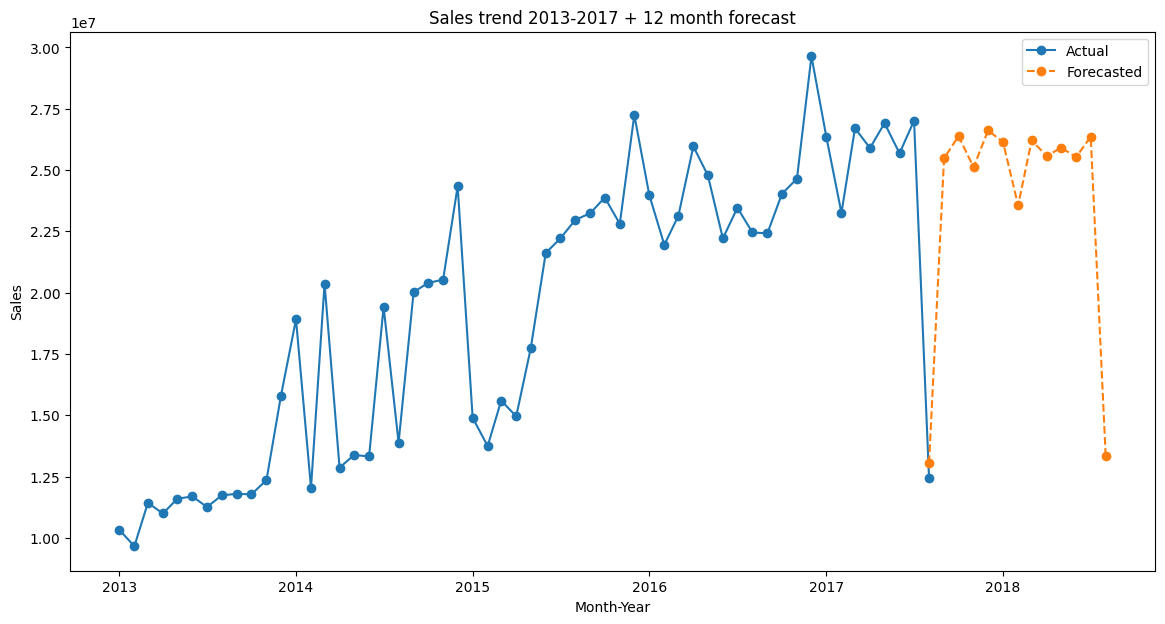

In [ ]:
monthly_sales_act = df['sales'].resample('MS').sum()
monthly_sales_fc = future_fc_final.resample('MS').sum()
# Plot the monthly sales
plt.figure(figsize=(14,7))

plt.plot(monthly_sales_act.index,monthly_sales_act.values,marker = 'o',label = 'Actual')
plt.plot(monthly_sales_fc.index,monthly_sales_fc.values,linestyle= '--', marker = 'o', label = 'Forecasted')

plt.title('Sales trend 2013-2017 + 12 month forecast')
plt.legend()
plt.xlabel('Month-Year')
plt.ylabel('Sales')

plt.show()

### 3.4 SARIMA Model to predict monthly sales

<Figure size 1000x500 with 0 Axes>

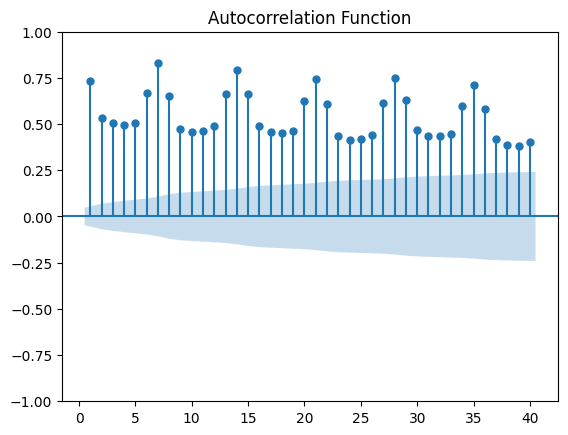

ADF Statistic: -2.0452868889089983
P-Value: 0.26707594130938095


In [ ]:
monthly_sales_act
# Check the stationalily of the monthly data 
result = adfuller(monthly_sales_act.values)  


# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(df['sales'], lags=40, zero=False)
plt.title('Autocorrelation Function')

plt.show()
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")


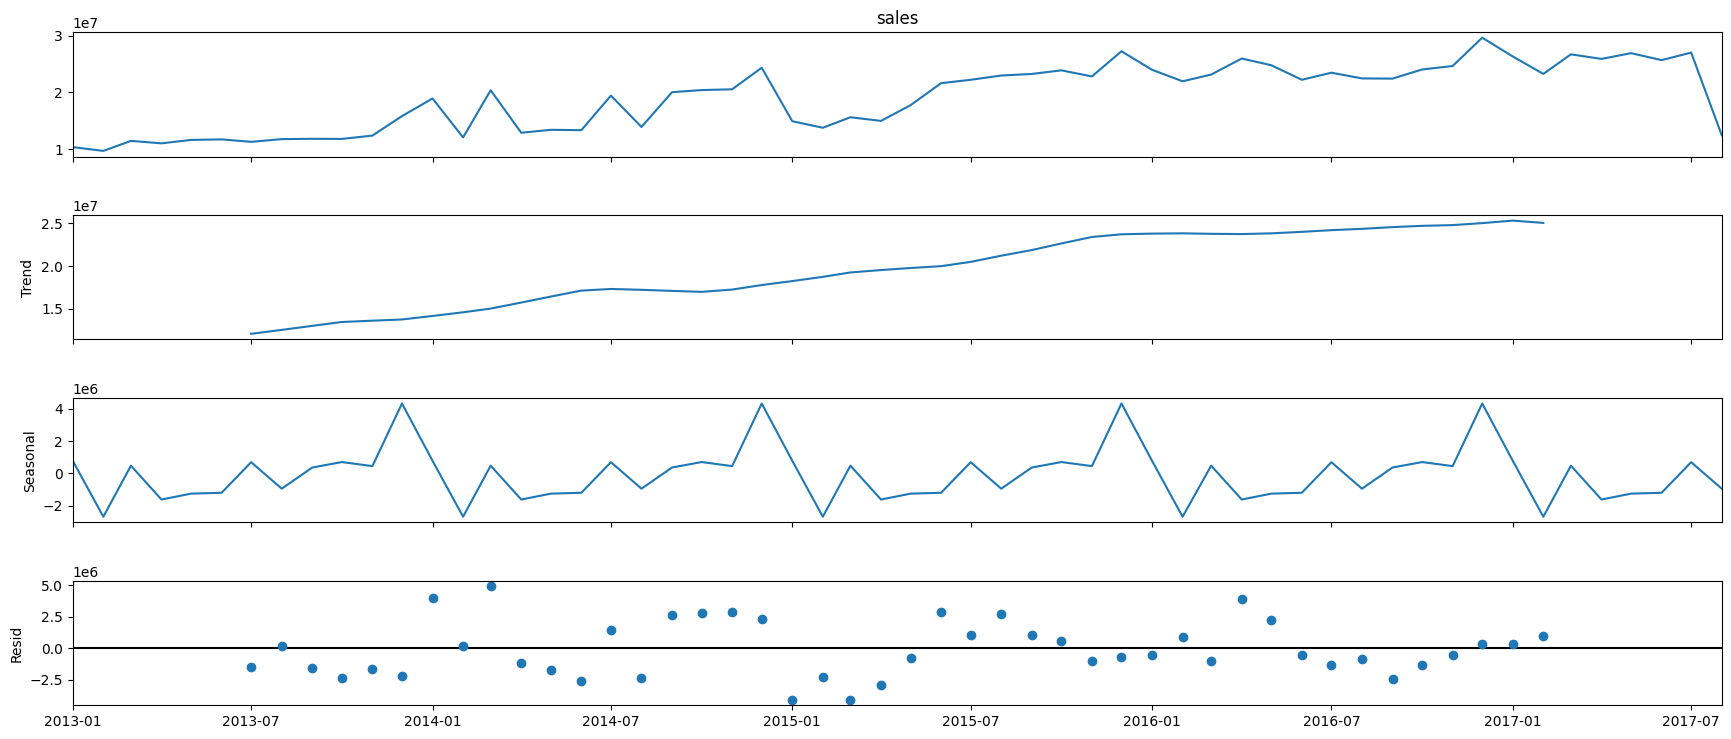

In [ ]:
# Check the seasonality of the dataset 
decomposition = sm.tsa.seasonal_decompose(monthly_sales_act, model='additive')
fig = decomposition.plot()
fig.set_size_inches(20, 8)

plt.show()

In [ ]:
# Differencing the dataset 
monthly_sales_diff = monthly_sales_act.diff(periods=1).dropna()

adf_test = adfuller(monthly_sales_diff)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

ADF Statistic: -10.042408864894924
P-value: 1.4843191951318274e-17


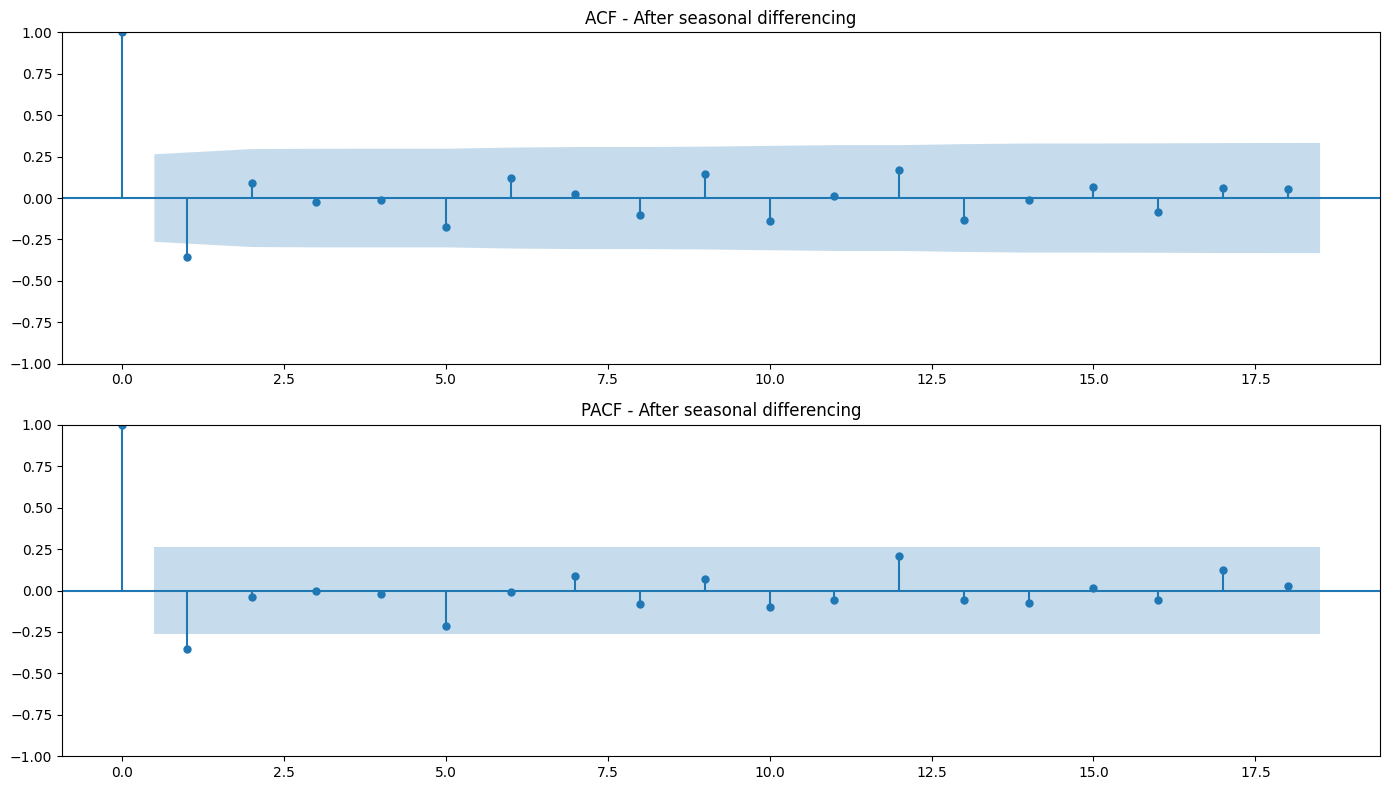

In [ ]:
# ACF and PACF of the differenced data 
# Initiate the plot 
fig,axes = plt.subplots(2,1,figsize = (14,8))


# ACF plot 
plot_acf(monthly_sales_diff.dropna(),ax=axes[0])
axes[0].set_title("ACF - After seasonal differencing")

# PACF 
plot_pacf(monthly_sales_diff.dropna(),ax=axes[1])
axes[1].set_title("PACF - After seasonal differencing")

plt.tight_layout()
plt.show()

In [ ]:
# Split the data set into training and testing sets 
split_month = '2016-06-01'
train_data_month = monthly_sales_act[monthly_sales_act.index <= split_month]
test_data_month = monthly_sales_act[monthly_sales_act.index > split_month]

In [ ]:
print(monthly_sales_act.head(5))
print(monthly_sales_diff.head(5))

date
2013-01-01    1.032762e+07
2013-02-01    9.658960e+06
2013-03-01    1.142850e+07
2013-04-01    1.099346e+07
2013-05-01    1.159770e+07
Freq: MS, Name: sales, dtype: float64
date
2013-02-01   -6.686650e+05
2013-03-01    1.769537e+06
2013-04-01   -4.350323e+05
2013-05-01    6.042393e+05
2013-06-01    9.164006e+04
Freq: MS, Name: sales, dtype: float64


In [ ]:
# Define the ranges for p, d, q, P, D, Q
p = [0,1,2]
d = [0]
q = [0,1,2]
P = range(0,6)
Q = range(0,5)
D = [1]
seasonal_period = 12 

# Call the function 
best_aic_order,best_aic_seasonal,best_aic,best_bic_order,best_bic_seasonal,best_bic = best_sarima(train_data_month,p,d,q,P,D,Q,seasonal_period)


✅ Best AIC Model: SARIMA(0, 0, 0)x(0, 1, 3, 12) - AIC: 8.0

✅ Best BIC Model: SARIMA(0, 0, 2)x(0, 1, 2, 12) - BIC: 103.25821862067677


In [ ]:
# Fit the model 

best_aic_order = [3,0,0]
best_aic_seasonal = [0,1,7,12]

order = best_aic_order
seasonal_order = best_aic_seasonal

# Train the model with the best "order"
monthly_sarima_model = SARIMAX(train_data_month, order = order,
                            seasonal_order = seasonal_order,
                            enforce_stationarity=False, 
                             enforce_invertibility=False)

# Fit the SARIMA model 
monthly_sarima_results = monthly_sarima_model.fit(disp=False)
aic_actual = monthly_sarima_results.aic

# Forecast with test data 
forecast_diff_month = monthly_sarima_results.forecast(steps = len(test_data_month))

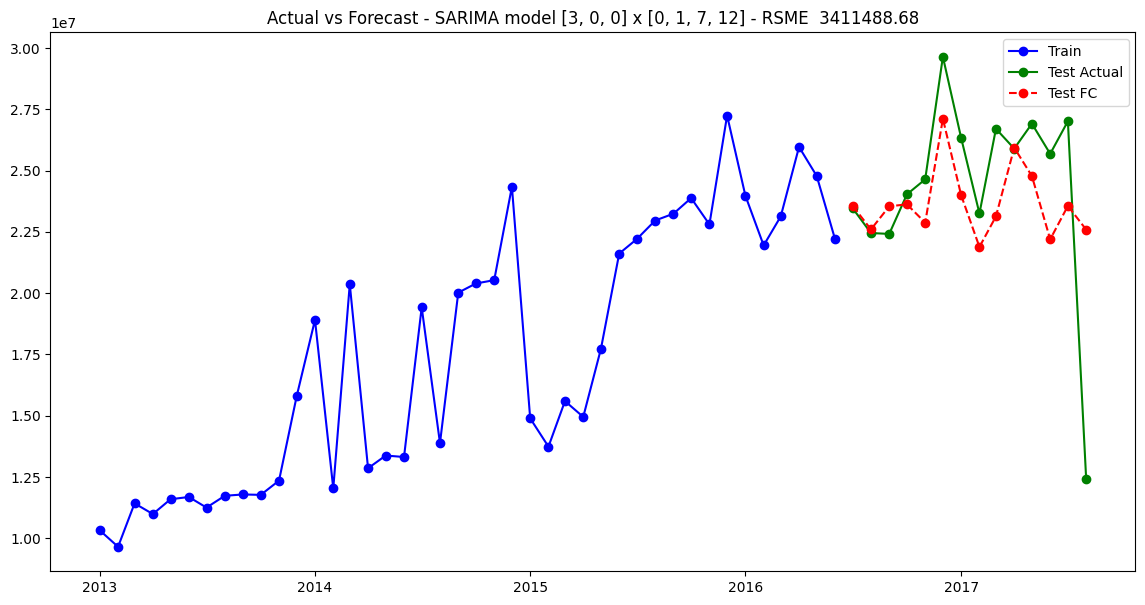

In [ ]:
# Calculate RSME
monthly_sarima_rsme = np.sqrt(mean_squared_error(test_data_month,forecast_diff_month))

# Plot the actual vs forecast of the train data 
plt.figure(figsize = (14,7))

plt.plot(train_data_month.index,train_data_month.values,label = "Train", marker = 'o', color = 'blue')
plt.plot(test_data_month.index,test_data_month.values,label = "Test Actual", marker = 'o', color = 'green')
plt.plot(forecast_diff_month.index,forecast_diff_month.values,label = "Test FC", marker = 'o', color = 'red', linestyle = '--')

plt.title(f'Actual vs Forecast - SARIMA model {best_aic_order} x {best_aic_seasonal} - RSME {monthly_sarima_rsme : .2f}')
plt.legend()

plt.show()

## 4. Forecast "transacions" using Xgboost model

In [83]:
trans_df= import_csv("transactions.csv")
trans_df['date'] = pd.to_datetime(trans_df['date'])

### 4.1. Prepare the dataframe

In [84]:
# Add sales value by merging with df_train 
sales_act_bystore = df_train.groupby(['date','store_nbr'])['sales'].sum().reset_index()
trans_df = trans_df.merge(sales_act_bystore,on = ['date','store_nbr'],how = 'left')

# Retrieve forecasted sales value 
sales_fc_bystore = total_fc.groupby(['date','store_nbr'])['sales'].sum().reset_index()
sales_fc_bystore = sales_fc_bystore.rename(columns={'sales':"sales_FC"})
trans_df = trans_df.merge(sales_fc_bystore,on = ['date','store_nbr'],how = 'left')

# replace actual sales value with forecasted value to simulate the implication of forecast model since 2014 
trans_df['sales_FC'] = trans_df['sales_FC'].fillna(trans_df['sales'])
trans_df = trans_df.drop(columns=['sales'])
trans_df = trans_df.rename(columns={'sales_FC':'sales'})

trans_df

C:\Users\PCPV\AppData\Local\Temp\ipykernel_30956\3893171542.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_act_bystore = df_train.groupby(['date','store_nbr'])['sales'].sum().reset_index()
C:\Users\PCPV\AppData\Local\Temp\ipykernel_30956\3893171542.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_fc_bystore = total_fc.groupby(['date','store_nbr'])['sales'].sum().reset_index()


,date,store_nbr,transactions,sales
0,2013-01-01,25,770,2511.618999
1,2013-01-02,1,2111,7417.148000
2,2013-01-02,2,2358,10266.718981
3,2013-01-02,3,3487,24060.348000
4,2013-01-02,4,1922,10200.083980
...,...,...,...,...
83483,2017-08-15,50,2804,23109.174190
83484,2017-08-15,51,1573,29889.454867
83485,2017-08-15,52,2255,1436.968829
83486,2017-08-15,53,932,2000.396832


In [85]:
# Merge with df_oil 
trans_df = trans_df.merge(df_oil,on='date',how='left')
trans_df['dcoilwtico'] = trans_df['dcoilwtico'].ffill()

# Fill missing dcoilwtico values with the next value 
trans_df['dcoilwtico'] = trans_df['dcoilwtico'].bfill()

In [86]:
#matching holidays
trans_df = pd.merge(trans_df, df_stores[['store_nbr','city','state']], on='store_nbr', how = 'left')
df_holidays['city'] = df_holidays['locale_name']
df_holidays['state'] = df_holidays['locale_name']

df_holidays['temp_col'] = 1
trans_df = pd.merge(trans_df, df_holidays[df_holidays['locale'] == 'Local'][['date', 'city', 'temp_col']], on=['date', 'city'], how='left')
trans_df['holiday_local'] = trans_df['temp_col'].fillna(0).astype(int)
trans_df.drop(columns=['temp_col'], inplace=True)

trans_df = pd.merge(trans_df, df_holidays[df_holidays['locale'] == 'Regional'][['date', 'state', 'temp_col']], on=['date', 'state'], how='left')
trans_df['holiday_regional'] = trans_df['temp_col'].fillna(0).astype(int)
trans_df.drop(columns=['temp_col'], inplace=True)

trans_df = pd.merge(trans_df, df_holidays[df_holidays['locale'] == 'National'][['date', 'temp_col']], on=['date'], how='left')
trans_df['holiday_national'] = trans_df['temp_col'].fillna(0).astype(int)
trans_df.drop(columns=['temp_col'], inplace=True)

#combine holidays
trans_df['holiday'] = trans_df['holiday_local'] + trans_df['holiday_regional'] + trans_df['holiday_national']
trans_df['is_holiday'] = trans_df['holiday'].apply(lambda x:1 if x>0 else 0)
trans_df.drop(columns=['holiday_local', 'holiday_regional', 'holiday_national','city', 'state'], inplace=True)

#matching store type and cluster
trans_df = pd.merge(trans_df, df_stores[['store_nbr','type','cluster']], on='store_nbr', how = 'left')



In [87]:
#add weekday and month
trans_df['weekday'] = trans_df['date'].dt.weekday
trans_df['month'] = trans_df['date'].dt.month

# Compute the expected drop at Jan 1st annually 
trans_df['1st_jan'] = np.logical_and(trans_df['date'].dt.month == 1, trans_df['date'].dt.day == 1) * 1
# jan1_avg = trans_df[trans_df['1st_jan'] == 1]['transactions'].mean()
# normal_avg = trans_df[trans_df['1st_jan'] != 1]['transactions'].mean()

# drop_pct = (normal_avg - jan1_avg) / normal_avg
# trans_df['jan1_drop'] = trans_df['1st_jan'] * drop_pct

#Add sales time-series data
trans_df['sales_7_ago'] = trans_df.groupby('store_nbr')['transactions'].shift(7)
trans_df['sales_30_ago'] = trans_df.groupby('store_nbr')['transactions'].shift(30)
trans_df['sales_last_year'] = trans_df.groupby('store_nbr')['transactions'].shift(365)
trans_df['sales_7_mean'] = (
    trans_df.groupby('store_nbr')['transactions']
    .rolling(window=7, min_periods=7, closed= 'left')  # closed = 'left' means ignoring the latest datapoint in the rolling windows
    .mean()
    .reset_index(level=[0, 1], drop=True)
)
trans_df['sales_30_mean'] = (
    trans_df.groupby('store_nbr')['transactions']
    .rolling(window = 30, min_periods=30, closed= 'left')
    .mean().reset_index(level=[0,1],drop=True)
)

# time delta between the date and the first date in the dataset
trans_df['day_n'] = (trans_df['date'] - np.min(trans_df['date'])).dt.days 

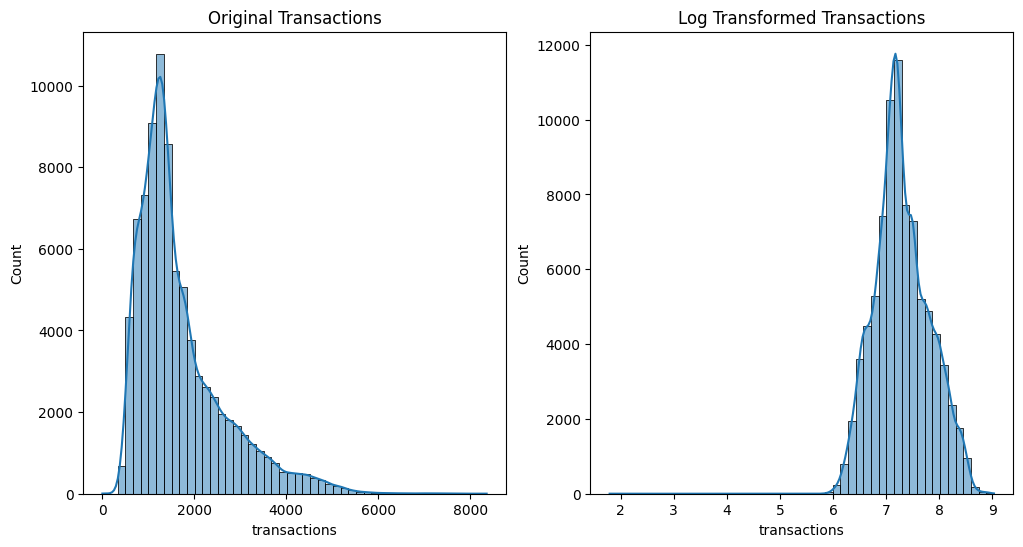

In [88]:
# Check the distributions of transactions volumes 
fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.histplot(trans_df['transactions'], bins=50,kde=True,ax=ax[0])
ax[0].set_title("Original Transactions")

sns.histplot(np.log1p(trans_df['transactions']), bins=50,kde=True,ax=ax[1])
ax[1].set_title("Log Transformed Transactions")

plt.show()

### 4.2 Features Creation

In [89]:
column_list = trans_df.columns.to_list
column_list

<bound method IndexOpsMixin.tolist of Index(['date', 'store_nbr', 'transactions', 'sales', 'dcoilwtico', 'holiday',
       'is_holiday', 'type', 'cluster', 'weekday', 'month', '1st_jan',
       'sales_7_ago', 'sales_30_ago', 'sales_last_year', 'sales_7_mean',
       'sales_30_mean', 'day_n'],
      dtype='object')>

In [90]:
# Prepare feature columns 
fearture_columns = ['store_nbr', 'holiday',
       'weekday', 'month', '1st_jan','sales_7_ago','type','cluster','sales',
       'sales_30_ago', 'sales_7_mean', 'sales_30_mean', 'day_n','dcoilwtico']
categorical_columns = ['store_nbr','weekday','month','type','cluster']

for col in categorical_columns:
    trans_df[col] = trans_df[col].astype('category')

In [91]:
end_date_original = trans_df['date'].max()
end_date_original

Timestamp('2017-08-15 00:00:00')

In [95]:
# Split the data into train and test sets 
split_date = '2016-06-01' # Split the test data from 2016 onward
train_data = trans_df[trans_df['date'] < split_date].copy()
test_data = trans_df[trans_df['date'] >=  split_date].copy()

# Prepare training data form model 
X_train = train_data[fearture_columns].copy()
y_train = train_data['transactions'].copy()
X_test = test_data[fearture_columns].copy()
y_test = test_data['transactions'].copy()

# Create weight for Jan 1st 
weights = np.where(X_train['1st_jan'] == 1, 4.0,1.0)

# LGB dataset 
train_lgb = lgb.Dataset(X_train,label = y_train,categorical_feature=categorical_columns)
test_lgb = lgb.Dataset(X_test,label=y_test,categorical_feature=categorical_columns,reference=train_lgb)


### 4.3 Build the Model

In [96]:
# Build the model
params = {
    'boosting_type':'gbdt',
    'objective':'tweedie',
    'metric':'rmse',
    'num_leaves':50,
    'learning_rate': 0.1,
    'feature_fraction':0.9,
    'seed' : 13
}

num_round = 1000
callbacks = [early_stopping(50)]

# Train the model 
transaction_model = lgb.train(params,train_lgb,num_round,valid_sets=[train_lgb,test_lgb],callbacks=callbacks)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 60639, number of used features: 13
[LightGBM] [Info] Start training from score 7.445751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's rmse: 180.847	valid_1's rmse: 244.425


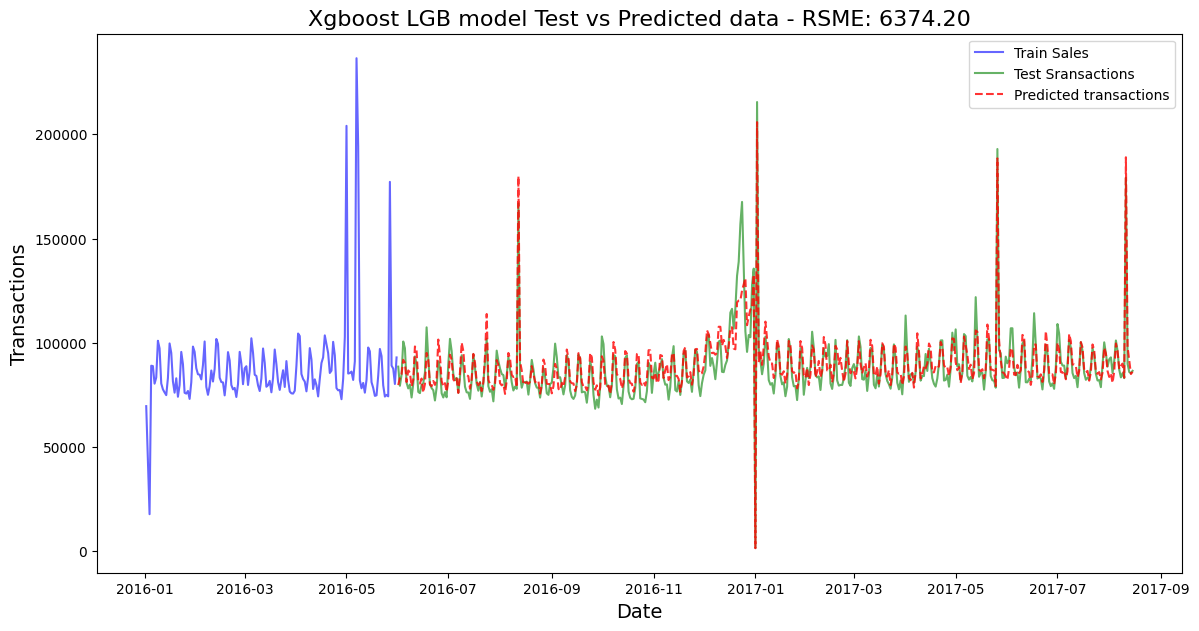

In [97]:
# Predict with the test date 
y_pred = transaction_model.predict(X_test,num_iteration=transaction_model.best_iteration)

# Revert the logarith transformation 
#y_pred = np.expm1(y_pred)

# Prepare the data for plotting 
y_train = train_data.groupby('date')['transactions'].sum().reset_index()
y_train = y_train.set_index('date')

test_data['transactions_pred'] = y_pred
test_group = test_data.groupby('date')[['transactions','transactions_pred']].sum().reset_index()
test_group = test_group.set_index('date')

# Calculate RSME 
transaction_rsme = np.sqrt(mean_squared_error(test_group['transactions'],test_group['transactions_pred']))

# Plot the chart 
plt.figure(figsize=(14, 7))

# Plot y_train
plt.plot(y_train.loc['2016-01-01':].index, y_train.loc['2016-01-01':]['transactions'], label='Train Sales', color='blue', alpha=0.6)

# Plot y_test
plt.plot(test_group.index, test_group['transactions'], label='Test Sransactions', color='green', alpha=0.6)

# Plot y_pred
plt.plot(test_group.index, test_group['transactions_pred'], label='Predicted transactions',linestyle="--", color='red', alpha=0.8)

plt.title(f'Xgboost LGB model Test vs Predicted data - RSME: {transaction_rsme:.2f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Transactions', fontsize=14)
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

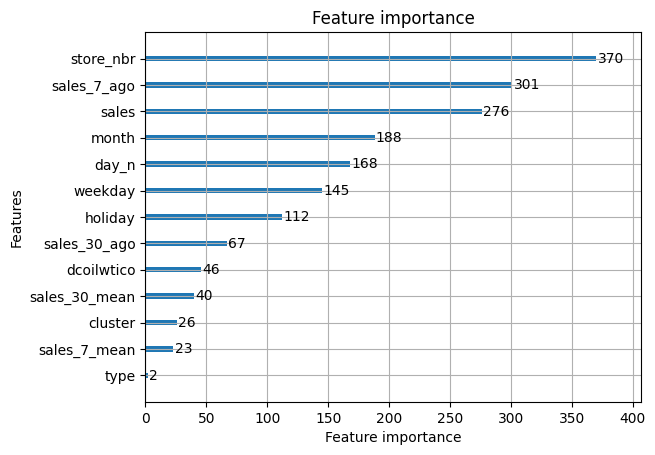

In [98]:
lgb.plot_importance(transaction_model)

### 4.4 Future Transaction Forecasts 
#### 4.4.1 Create feature columns for future forecast (12 months)

In [110]:
from itertools import product

fc_period = pd.to_datetime('2017-08-16') + pd.DateOffset(months=12) # forercast into 12 months in the future 

# Prepare data for model prediction 
date_range = pd.date_range(start='2017-08-16', end=fc_period, freq='D')  
unique_stores = df_stores['store_nbr'].unique()

# Create a DataFrame with all combinations of dates and store_nbr
fc_transactions = pd.DataFrame(list(product(date_range, unique_stores)), columns=['date', 'store_nbr'])

In [111]:
# Match with total_fc 
fc_transactions = fc_transactions.merge(sales_fc_bystore,on=['date','store_nbr'],how = 'left')

fc_transactions = fc_transactions.rename(columns={"sales_FC": "sales"})


In [112]:
# merge fc_transactions with df_stores,
fc_transactions = fc_transactions.merge(df_stores,on="store_nbr",how='left')


# create "dcoilwtico" with the latest oil price from df_oil 
latest_dcoil = df_oil[df_oil['date'] == df_oil['date'].max()]['dcoilwtico'].values[0]
fc_transactions['dcoilwtico'] = latest_dcoil


In [113]:
#matching holidays 
fc_transactions = pd.merge(fc_transactions, df_holidays[df_holidays['locale'] == 'Local'][['date', 'city', 'temp_col']], on=['date', 'city'], how='left')
fc_transactions['holiday_local'] = fc_transactions['temp_col'].fillna(0).astype(int)
fc_transactions.drop(columns=['temp_col'], inplace=True)

fc_transactions = pd.merge(fc_transactions, df_holidays[df_holidays['locale'] == 'Regional'][['date', 'state', 'temp_col']], on=['date', 'state'], how='left')
fc_transactions['holiday_regional'] = fc_transactions['temp_col'].fillna(0).astype(int)
fc_transactions.drop(columns=['temp_col'], inplace=True)

fc_transactions = pd.merge(fc_transactions, df_holidays[df_holidays['locale'] == 'National'][['date', 'temp_col']], on=['date'], how='left')
fc_transactions['holiday_national'] = fc_transactions['temp_col'].fillna(0).astype(int)
fc_transactions.drop(columns=['temp_col'], inplace=True)

#combine holidays
fc_transactions['holiday'] = fc_transactions['holiday_local'] + fc_transactions['holiday_regional'] + fc_transactions['holiday_national']
fc_transactions['is_holiday'] = fc_transactions['holiday'].apply(lambda x:1 if x>0 else 0)
fc_transactions.drop(columns=['holiday_local', 'holiday_regional', 'holiday_national','city', 'state'], inplace=True)


In [114]:
# #add weekday and month
fc_transactions['weekday'] = fc_transactions['date'].dt.weekday
fc_transactions['month'] = fc_transactions['date'].dt.month
fc_transactions['1st_jan'] = np.logical_and(fc_transactions['date'].dt.month == 1, fc_transactions['date'].dt.day == 1) * 1

# time delta between the date and the first date in the dataset
fc_transactions['day_n'] = (fc_transactions['date'] - np.min(trans_df['date'])).dt.days 

In [116]:
# Concat new future df with historical df 
fc_transactions = pd.concat([trans_df,fc_transactions],axis=0)
fc_transactions['date'] = pd.to_datetime(fc_transactions['date'])
fc_transactions = fc_transactions.sort_values('date')

fc_transactions['sales_7_ago'] = fc_transactions['transactions'].shift(7)
fc_transactions['sales_30_ago'] = fc_transactions['transactions'].shift(30)
fc_transactions['sales_last_year'] = fc_transactions['transactions'].shift(365)
fc_transactions['sales_7_mean'] = (
    fc_transactions.groupby('store_nbr')['transactions']
    .rolling(window=7, min_periods=7, closed= 'left')  # closed = 'left' means ignoring the latest datapoint in the rolling windows
    .mean()
    .reset_index(level=[0, 1], drop=True)
)
fc_transactions['sales_30_mean'] = (
    fc_transactions.groupby('store_nbr')['transactions']
    .rolling(window = 30, min_periods=30, closed= 'left')
    .mean().reset_index(level=[0,1],drop=True)
)


In [119]:
date_fc_list = fc_transactions['date'].unique().tolist()


In [120]:
# Create rolling lag feature columns and leave them as null
fc_trans_data = fc_transactions.copy()
fc_trans_data['sales_7_ago_roll'] = np.nan 
fc_trans_data['sales_30_ago_roll'] = np.nan 
fc_trans_data['sales_7_mean_roll'] = np.nan
fc_trans_data['sales_30_mean_roll'] = np.nan

fc_trans_data['fc_trans_rolls'] = fc_trans_data['transactions']

# Feature columns for predict df:
rolling_features = ['store_nbr', 'holiday',
       'weekday', 'month', '1st_jan', 'sales_7_ago_roll','type','cluster','sales',
       'sales_30_ago_roll', 'sales_7_mean_roll', 'sales_30_mean_roll', 'day_n','dcoilwtico']

# Predict values step by step, use the predicted value to predict the next value
for date in date_fc_list: 
       # Calculate lag features based on latest prediction 
       fc_trans_data['sales_7_ago_roll'] = fc_trans_data.groupby(['store_nbr'],observed=False)['fc_trans_rolls'].shift(7)
       fc_trans_data['sales_30_ago_roll'] = fc_trans_data.groupby(['store_nbr'],observed=False)['fc_trans_rolls'].shift(30)
       fc_trans_data['sales_7_mean_roll'] = (fc_trans_data.groupby(['store_nbr'],observed=False)['fc_trans_rolls']
                                        .rolling(window=7,min_periods=7,closed='left')
                                        .mean().reset_index(level=[0,1],drop=True)
                                        )
       fc_trans_data['sales_30_mean_roll'] = (fc_trans_data.groupby(['store_nbr'],observed=False)['fc_trans_rolls']
                                        .rolling(window=30,min_periods=30,closed='left')
                                        .mean().reset_index(level=[0,1],drop=True)
                                        )
    
       # Prepare the df to predict for future date 
       mask = fc_trans_data['date'] == date 
       predict_set = fc_trans_data.loc[mask,rolling_features].copy()
       for col in categorical_columns:
              predict_set[col] = predict_set[col].astype('category')

       forecast_result = transaction_model.predict(predict_set,num_iteration=transaction_model.best_iteration)
       fc_trans_data.loc[mask,'fc_trans_rolls'] = np.round(forecast_result,0)



In [122]:

# Combine the actual and forecasted values 
total_trans = fc_trans_data[fc_trans_data['date']>= '2014-01-01'].copy()
total_trans['transactions'] = total_trans['fc_trans_rolls']
total_trans = total_trans.drop(columns="fc_trans_rolls")
total_trans['status'] = "FC"

total_trans = total_trans[['date', 'store_nbr', 'transactions','status']]
total_trans.to_csv("total_fc_transactions.csv",index=False)

In [123]:
total_trans

,date,store_nbr,transactions,status
16956,2014-01-01,36,970.0,FC
16955,2014-01-01,25,1077.0,FC
17001,2014-01-02,51,1968.0,FC
16981,2014-01-02,28,1218.0,FC
16982,2014-01-02,30,909.0,FC
...,...,...,...,...
19750,2018-08-16,22,867.0,FC
19751,2018-08-16,23,1060.0,FC
19752,2018-08-16,24,2433.0,FC
19740,2018-08-16,12,1197.0,FC


In [99]:
# # Extract the FC data 
# transactions_xg = fc_transactions[fc_transactions['date'] >= '2017-08-15'][['date', 'store_nbr', 'transactions']]
# # transactions_xg['status'] = "FC"

# transactions_xg.to_csv("transactions_xg.csv",index=False,header=True)


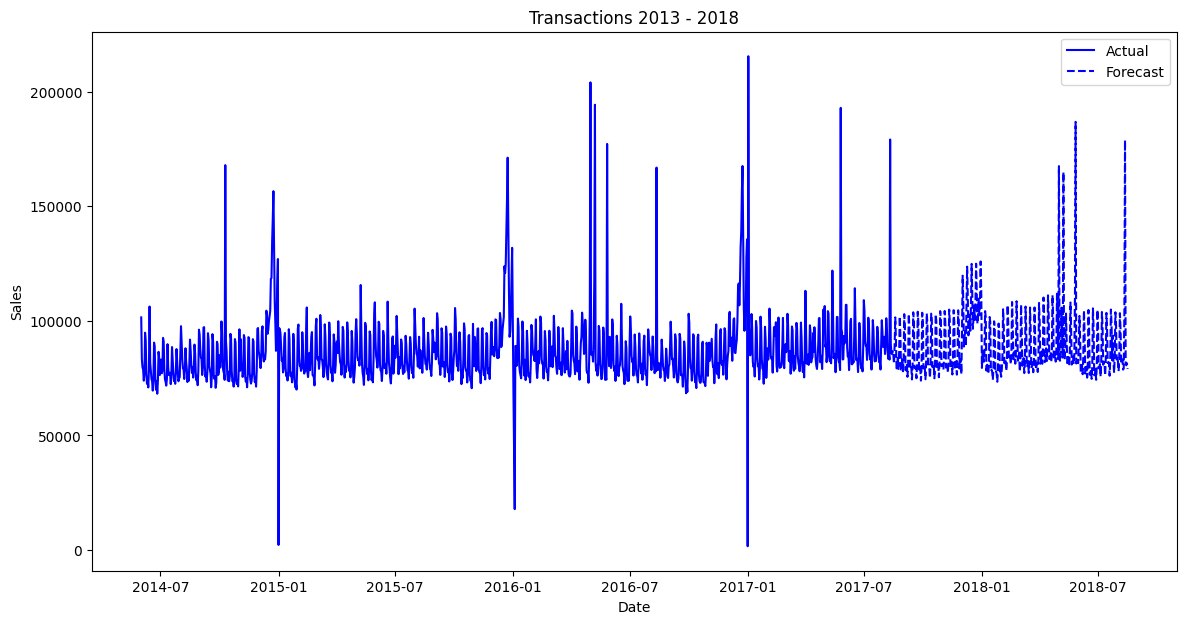

In [438]:
# Prepare df fro plotting 
fc_group = total_trans.groupby('date')['transactions'].sum().reset_index()
fc_group = fc_group.set_index('date')

trans_df_group = trans_df.groupby('date')['transactions'].sum().reset_index()
trans_df_group = trans_df_group.set_index('date')

# Plot the actual and predicted sales
plt.figure(figsize=(14,7))

plt.plot(trans_df_group.loc['2014-06-01':'2017-08-15'].index,trans_df_group.loc['2014-06-01':'2017-08-15']['transactions'],label="Actual",color = "blue")
plt.plot(fc_group.loc['2017-08-16':].index,fc_group.loc['2017-08-16':]['transactions'],label="Forecast",color = "blue", linestyle = "--")

plt.title("Transactions 2013 - 2018")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.show()



In [ ]:
fc_group = fc_group['transactions'].resample('MS').sum()
trans_df_group = trans_df_group['transactions'].resample('MS').sum()

plt.figure(figsize=(14,7))

plt.plot(trans_df_group.index,trans_df_group.values,marker = 'o',label = 'Actual',alpha = 0.6, color = 'blue')
plt.plot(fc_group.index,fc_group.values,marker = 'o',label = 'Forecast',alpha = 0.6, color = 'red',linestyle = "--")

plt.title('Transactions trend 2013-2017 + 12 month forecast ')
plt.xlabel("Month-Year")
plt.ylabel("Sales")
plt.legend()

plt.show()